# Task 3: Classification
## Predicting Fatality in Gun Incidents: A Classification Analysis

This notebook employs classification algorithms to predict the likelihood of fatalities in gun incidents using historical data. In an era marked by increased concerns about public safety, understanding the factors influencing the severity of such incidents is crucial.

We explore various machine learning techniques, including decision trees, support vector machines, and ensemble methods, to build a predictive model. Utilizing a comprehensive dataset featuring geographical, incident, and socio-economic details, we aim to uncover patterns that contribute to fatal outcomes.

Join us in this exploration of classification algorithms, as we seek to enhance our understanding of gun incidents and contribute to preemptive measures for public safety.

We will run, compare and discuss the performance of **10 different models**:

**Neighbors-based classifiers**
- K-Nearest Neighbors
- Radius-Neighbors

**Support Vector Machine**
- Support Vector Classification

**Machine Learning classifiers**
- Feed-forward Neural Network
- Multi-layer Perceptron

**Naive Bayes classifiers**
- Gaussian Naive Bayes
- Multinomial Naive Bayes

**Tree-based classifiers**
- Decision tree

**Ensemble Method**
- Random forest
- Voting classifier

### Import basic libraries

In [33]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics

### Import dataset

In [34]:
path_to_datasets = '../datasets'
path_to_cleaned = '/datasets_cleaned'

join_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_dataframe.csv')
join_external_dataframe = pd.read_csv(f'{path_to_datasets}{path_to_cleaned}/join_external_dataframe.csv')

numeric_columns_to_clusterize = ['incidents_state_year', 'severity_index',
                                 'percentage_males', 'percentage_adults',
                                 'age_combined_index', 'povertyPercentage',
                                 'percentage_votes', 'n_killed', 'n_injured',
                                 'n_unharmed', 'n_arrested', 'n_participants']

categorical_columns_to_clusterize = ['state']

incidents_num = join_dataframe[numeric_columns_to_clusterize].copy().sample(frac=0.4, random_state=42)
incidents_cat = join_dataframe[categorical_columns_to_clusterize].copy().sample(frac=0.4, random_state=42)

incidents_num.dropna(inplace=True)
incidents_cat.dropna(inplace=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [35]:
incidents_num.head()

incidents_state_year  severity_index  percentage_males  \
164355                   969        1.000000        100.000000   
66449                    511        0.500000        100.000000   
131646                   528        0.000000        100.000000   
104558                  2082        0.500000        100.000000   
25204                   1436        0.666667         66.666667   

        percentage_adults  age_combined_index  povertyPercentage  \
164355              100.0               31.75                9.1   
66449               100.0               32.00               12.8   
131646              100.0               39.00                9.2   
104558              100.0               31.00               11.8   
25204               100.0               25.25               14.9   

        percentage_votes  n_killed  n_injured  n_unharmed  n_arrested  \
164355         85.673629       0.0        2.0         0.0         0.0   
66449         100.000000       0.0        1.0         1.0         0.0   
131646         81.055553       0.0        0.0         0.0         1.0   
104558         81.176466       0.0        1.0         1.0         0.0   
25204          86.513678       1.0        1.0         0.0         1.0   

        n_participants  
164355             2.0  
66449              2.0  
131646             1.0  
104558             2.0  
25204              3.0

In [36]:
incidents_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30897 entries, 164355 to 107027
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   incidents_state_year  30897 non-null  int64  
 1   severity_index        30897 non-null  float64
 2   percentage_males      30897 non-null  float64
 3   percentage_adults     30897 non-null  float64
 4   age_combined_index    30897 non-null  float64
 5   povertyPercentage     30897 non-null  float64
 6   percentage_votes      30897 non-null  float64
 7   n_killed              30897 non-null  float64
 8   n_injured             30897 non-null  float64
 9   n_unharmed            30897 non-null  float64
 10  n_arrested            30897 non-null  float64
 11  n_participants        30897 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 3.1 MB


### Transform categorical features into numerical ones

In [37]:
def discretize_data(dataset, variables):
    for variable in variables:
        var = sorted(dataset[variable].unique())
        mapping = dict(zip(var, range(0, len(var) + 1)))
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

### Compute labels

In [38]:
incidents_num['isMurder'] = incidents_num['n_killed'] != 0

incidents_num = incidents_num.drop(['n_killed'], axis=1)
incidents_num = incidents_num.drop(['severity_index'], axis=1)

#### Balancing the data 

In [39]:
from sklearn.utils import resample

# Assuming '1' is the majority class and '0' is the minority class
minority_class = incidents_num[incidents_num['isMurder'] == 1]
majority_class = incidents_num[incidents_num['isMurder'] == 0]

# Undersampling the majority class
majority_class_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combining the undersampled majority class with the minority class
incidents_num = pd.concat([minority_class, majority_class_undersampled])

# Check the class distribution after undersampling
print(incidents_num['isMurder'].value_counts())

isMurder
True     8770
False    8770
Name: count, dtype: int64


In [40]:
incidents_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17540 entries, 25204 to 11650
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   incidents_state_year  17540 non-null  int64  
 1   percentage_males      17540 non-null  float64
 2   percentage_adults     17540 non-null  float64
 3   age_combined_index    17540 non-null  float64
 4   povertyPercentage     17540 non-null  float64
 5   percentage_votes      17540 non-null  float64
 6   n_injured             17540 non-null  float64
 7   n_unharmed            17540 non-null  float64
 8   n_arrested            17540 non-null  float64
 9   n_participants        17540 non-null  float64
 10  isMurder              17540 non-null  bool   
dtypes: bool(1), float64(9), int64(1)
memory usage: 1.5 MB


### Preparing the training set and test set

In [41]:
labels = []
for index, isMurder in incidents_num.isMurder.items():
    if isMurder == True:
        labels.append(0)
    else:
        labels.append(1)

In [42]:
class_names=['No murder', 'Murder']

### Population of the classes

In [43]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts()

labels
0    8770
1    8770
Name: count, dtype: int64

### Preparing the training set and test set

In [44]:
from sklearn.model_selection import train_test_split
incidents_num.drop(columns=['isMurder'], inplace=True)
train_set, test_set, train_label, test_label = train_test_split(incidents_num, labels, stratify=labels, test_size=0.3)

### Aiding the implementation and evaluation of the classifiers with utility functions

In [45]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

#### Add labels on top of bar from bar plots

In [46]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        target = axs[i][j]
    elif i != None:
        target = axs[i]
    else:
        target = axs    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        target.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

#### Display correlations among the attributes

In [47]:
def display_corr(df, corr_threshold = 0.8):
    print('Correlations')
    print("Att. A\tAtt. B\tCorr(A,B)")
    for i in range(0, len(df.columns)):
        for j in range(i+1, len(df.columns)):
            corr = df[df.columns[i]].corr(df[df.columns[j]])
            if  corr > corr_threshold:
                print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

#### Print the classification scores

In [48]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred))

#### Identify the misclassification of a classifier

In [49]:
def spot_errors(test_label, test_pred):
    spot_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
        else:
            spot_errors.append('darkgray')
    return spot_errors

#### Compares the true labels with the one predicted by a classifier while displaying the misclassification

In [50]:
# incidents_state_year	severity_index	percentage_males	percentage_adults	age_combined_index	povertyPercentage	percentage_votes	n_killed	n_injured	n_unharmed	n_arrested

def classification_visualizer(test_set, test_label, test_pred, classifier_name):
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    a, b = 'incidents_state_year', 'povertyPercentage'
    errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    for i in range(2):
        axs[i].scatter(test_set[a], test_set[b], c=labels[i], s=20, cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})
    plt.suptitle(('Visualization of the ' + classifier_name + ' classifier on the test set'),
                 fontsize=24, fontweight='bold')
    plt.show()

#### Plot the confusion matrix of a classifier

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_c_matrix(test_set, test_label, test_pred, classifier, classifier_name, axs=None):
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()
    plt.title('Confusion matrix of ' + classifier_name)
    plt.show() 

#### Plot the decision boundary of a classifier

In [52]:
import itertools
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

def plot_decision_boundary(train_set, train_label, classifier, classifier_name, axs=None):
    X = train_set.values
    y = np.array(train_label)
    pca = PCA(n_components = 2)
    X = pca.fit_transform(X)
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(20,10))
    labels = [classifier_name]
    for clf, lab, grd in zip([classifier],
                         labels,
                         itertools.product([0, 1], repeat=2)):
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        if axs:
            fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2, ax=axs)
        else:
            fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title('Decision boundary of ' + lab)

## Classifiers 

### K-Nearest Neighbors

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data.

#### Import libraries

In [53]:
from sklearn.neighbors import KNeighborsClassifier

#### Pre-processing

As for many of the classifiers, KNN works best with a dataset that is free of irrelevant and redundant attributes. The former add noise to the proximity measure while the latter introduce bias towards certain attributes. Ultimately, the classifier tends to benefit from dimensionality reduction and variable selection.

Additionally, attributes may need to be resized to prevent distance measurements from being dominated by one of the attributes. We now provide a normalized version of the training and test sets for use during some of the later tests on the classifier accuracy.

In [54]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
incidents_num_norm_minmax = minmax_scaler.fit_transform(incidents_num.values)
norm_train_set, norm_test_set, norm_train_label, norm_test_label = train_test_split(incidents_num_norm_minmax, labels, stratify=labels, test_size=0.10)

#### Grid search

We proceed by using a grid search in order to identify the optimal values for parameters necessary for the execution of the classification task. The parameters are: 

The number of neighbors, **K**:
- a small value for k induces a susceptibility to outliers and noise points;
- a large k makes the classification boundaries less defined;

We decide to analyze a range of 16 values starting from the closest single neighbor.

In [55]:
k_range = range(1,16)

The **proximity metric**, used to calculate the distance between the points under analysis. In general it can be any metric measure, the standard Euclidean distance tends to be the most common choice but we decide to add other derivatives of the Minkowski Distance to the research:
- Euclidean distance
- Manhattan distance

In [56]:
knn_metrics = ['euclidean', 'manhattan']

The **weight function** used when classifying unknown points, the method of using the class labels of the nearest neighbors K to determine the class label of the new record. The neighbors can contribute by:
- a majority vote 
- by weighting the vote according to their distance from the new record

In [57]:
knn_weights = ['uniform', 'distance']

The **algorithm** used to compute the nearest neighbors, it can be:
- brute, the most naive neighbor search implementation that involves the brute-force computation of distances between all pairs of points in the dataset (it can be very competitive for small data samples);
- kd_tree, short for K-dimensional tree, that tries to reduce the required number of distance calculations by encoding aggregate distance information for the sample (it is very fast for low-dimensional neighbors searches);
- ball_tree, that tries to address the inefficiencies of KD Trees in higher dimensions.

In [58]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

The algorithm parameter also has the default value "auto", which means that the choice of the optimal algorithm is left to the classifier. Some tests are carried out to verify the reliability of this practice.

This is the parameters grid set up for the search.

In [59]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
}

We use the GridSearchCV function to implement the search. The cv parameters represent the number of folds employed within the cross validation of each possible set of values for the parameters described above. The scoring method employed to compare the different version of the classifier is the accuracy.  

In [60]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, n_jobs=-1, cv=4, scoring='accuracy')
knn_grid.fit(train_set, train_label)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 16),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

NOTE:
The error above is caused by a known bug in scikit-learn 1.3.0. We still didn't want to downgrade to 1.2.2 only for this reason.

After fitting the model to the dataset the search results is these values for the parameters and the accuracy of the classifier. 

In [61]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.652303586458257
Parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


We proceed with additional test regarding the use of the "auto" value for the algorithm parameter.

##### Letting the classifier choose the algorithm: algorithm = 'auto' 

The expected result is that, as happened in the previous grid research, the ball tree algorithm will be implicitly chosen by the classifier and, as such, there will be no substantial changes in the accuracy of the resulting model.

In [62]:
knn_param_grid_auto = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'weights': knn_weights
}

In [63]:
knn_grid_auto = GridSearchCV(KNeighborsClassifier(), knn_param_grid_auto, n_jobs=-1, cv=4, scoring='accuracy')
knn_grid_auto.fit(train_set, train_label)

print('Accuracy: ' + str(knn_grid_auto.best_score_))
print('Parameters: ' + str(knn_grid_auto.best_params_))

Accuracy: 0.652303586458257
Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


The conclusions mentioned above have been fully respected, so we now proceed with a test regarding the performance of the classifier in relation to a normalized version of the dataset.

#### Normalized datasets 

In [64]:
knn_grid_norm = GridSearchCV(KNeighborsClassifier(), knn_param_grid, n_jobs=-1, scoring='accuracy')
knn_grid_norm.fit(norm_train_set, norm_train_label)

print('Accuracy: ' + str(knn_grid_norm.best_score_))
print('Parameters: ' + str(knn_grid_norm.best_params_))

Accuracy: 0.9293678532962426
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


The transition to the normalized dataset seems to have increased the performance of the classifier, at least in the training phase.
For this reason, the fitting and evaluation phases will continue with the normalized version of the dataset.

As already mentioned while introducing this particular kind of classifier, instance-based classifier don't traditionally present a training phase but simply stores instances of the training data. Therefore, after fitting the data to the model we will proceed with the testing and evaluation phases.

#### Fitting the classifier

In [65]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(train_set, train_label)

#### Test

We use the classifier to predict the label of the records contained within our test set.

In [66]:
test_pred_knn = knn.predict(test_set)

#### Evaluation

Here we evaluate the performance of the classifier with respect to the test set.

In [67]:
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

           0       0.66      0.69      0.68      2631
           1       0.68      0.65      0.66      2631

    accuracy                           0.67      5262
   macro avg       0.67      0.67      0.67      5262
weighted avg       0.67      0.67      0.67      5262



#### Visualization of the classifier results via scatterplots
Here we display the spatial arrangement of both the true and predicted label with respect to the feature space of two the dataset attributes. 
<br>Within the third scatter plot, the misclassification performed by the classifier are highlighted in red. 

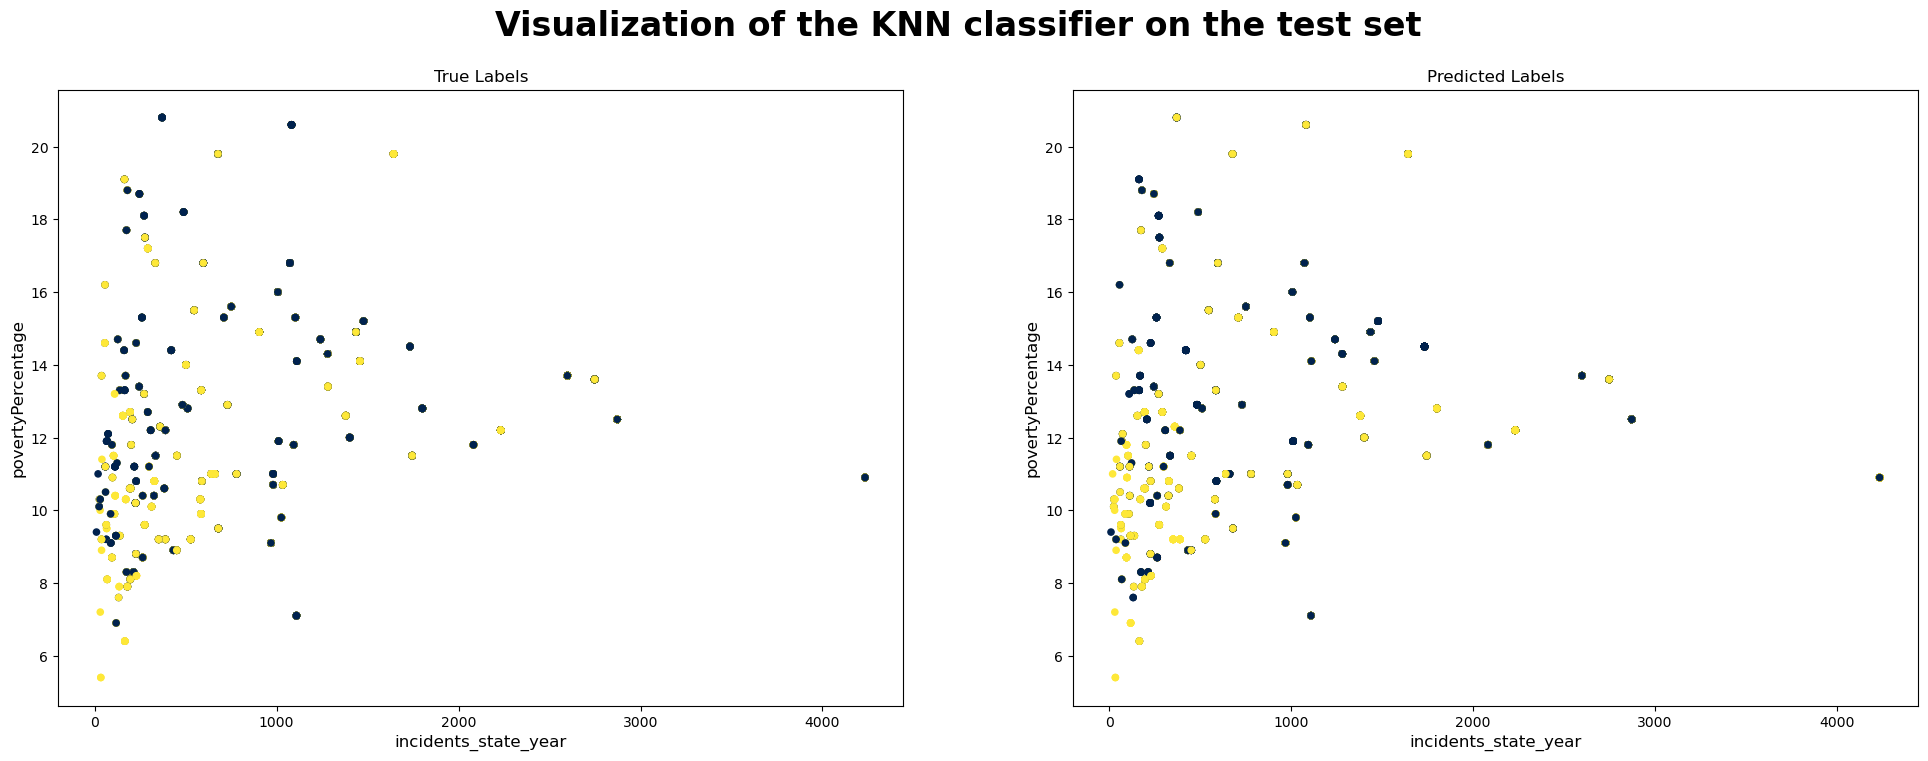

In [68]:
classification_visualizer(test_set, test_label, test_pred_knn, 'KNN')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that **this model is quite accurate** as it did not make excessive errors in the prediction.

##### Confusion Matrix of the classifier
Here we display the confusion matrix referring to the classifier performance.

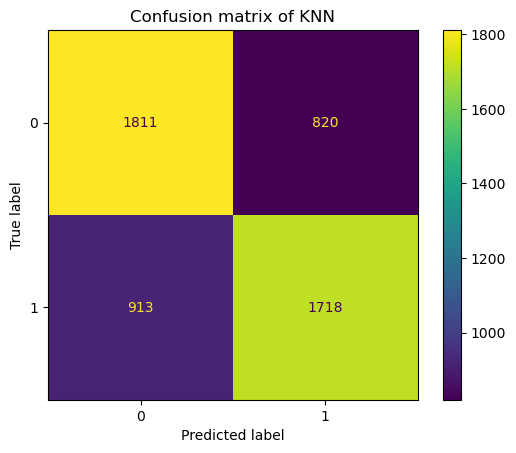

In [69]:
plot_c_matrix(test_set, test_label, test_pred_knn, knn, 'KNN')

The class that reports the major number of errors is that of medium spending, erroneously classified most often as high spending.

##### Visualization of the decision boundary of the classifier

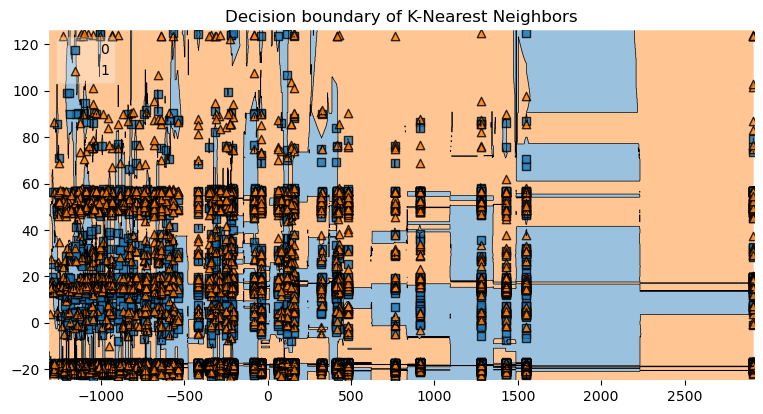

In [70]:
plot_decision_boundary(train_set, train_label, knn, 'K-Nearest Neighbors')

# ------------------------------

### Radius-Neighbors Classifier 

In cases where the record from the dataset tends to be not uniformly sampled, Radius-based Neighbors Classification can provide better results.

#### Import libraries

In [71]:
from sklearn.neighbors import RadiusNeighborsClassifier

#### Grid search

We utilize again the grid search in order to identify the optimal values for classifier parameters. These parameters are for the most part the same calculated for the KNN classifier, the only difference lies in the replacement of the parameter k, number of neighbors, with the parameter r, the radius within which to search for neighbors.

We set up a range of possible values for r and perform the actual grid search.

In [72]:
from scipy.stats import uniform
radius = uniform(1.0, 100.0)
radius_param_grid = {
    'radius': radius,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [73]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=2, n_iter = 20, scoring='accuracy')
radius_grid.fit(train_set, train_label)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^

RandomizedSearchCV(estimator=RadiusNeighborsClassifier(), n_iter=20, n_jobs=2,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan'],
                                        'radius': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbeef2a7110>,
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

After fitting the model to the dataset, the search results is these values for the parameters and the accuracy of the classifier. 

In [74]:
print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.5480528005731837
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'radius': 74.45050364317608, 'weights': 'uniform'}


Once again we proceed with the fitting, testing and evaluation of the model. 

#### Fitting the classifier

In [75]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set, train_label)

#### Test

In [76]:
test_pred_radius = radius.predict(test_set)

#### Evaluation

In [77]:
report_scores(test_label,test_pred_radius)

              precision    recall  f1-score   support

           0       0.55      0.66      0.60      2631
           1       0.58      0.46      0.51      2631

    accuracy                           0.56      5262
   macro avg       0.56      0.56      0.56      5262
weighted avg       0.56      0.56      0.56      5262



In this case the value of accuracy for the model is quite good enough, but not excellent.

The metrics (precision, recall and f1-score) confirms again to be the best for the low-spending class.

##### Visualization of the classifier results via scatterplots

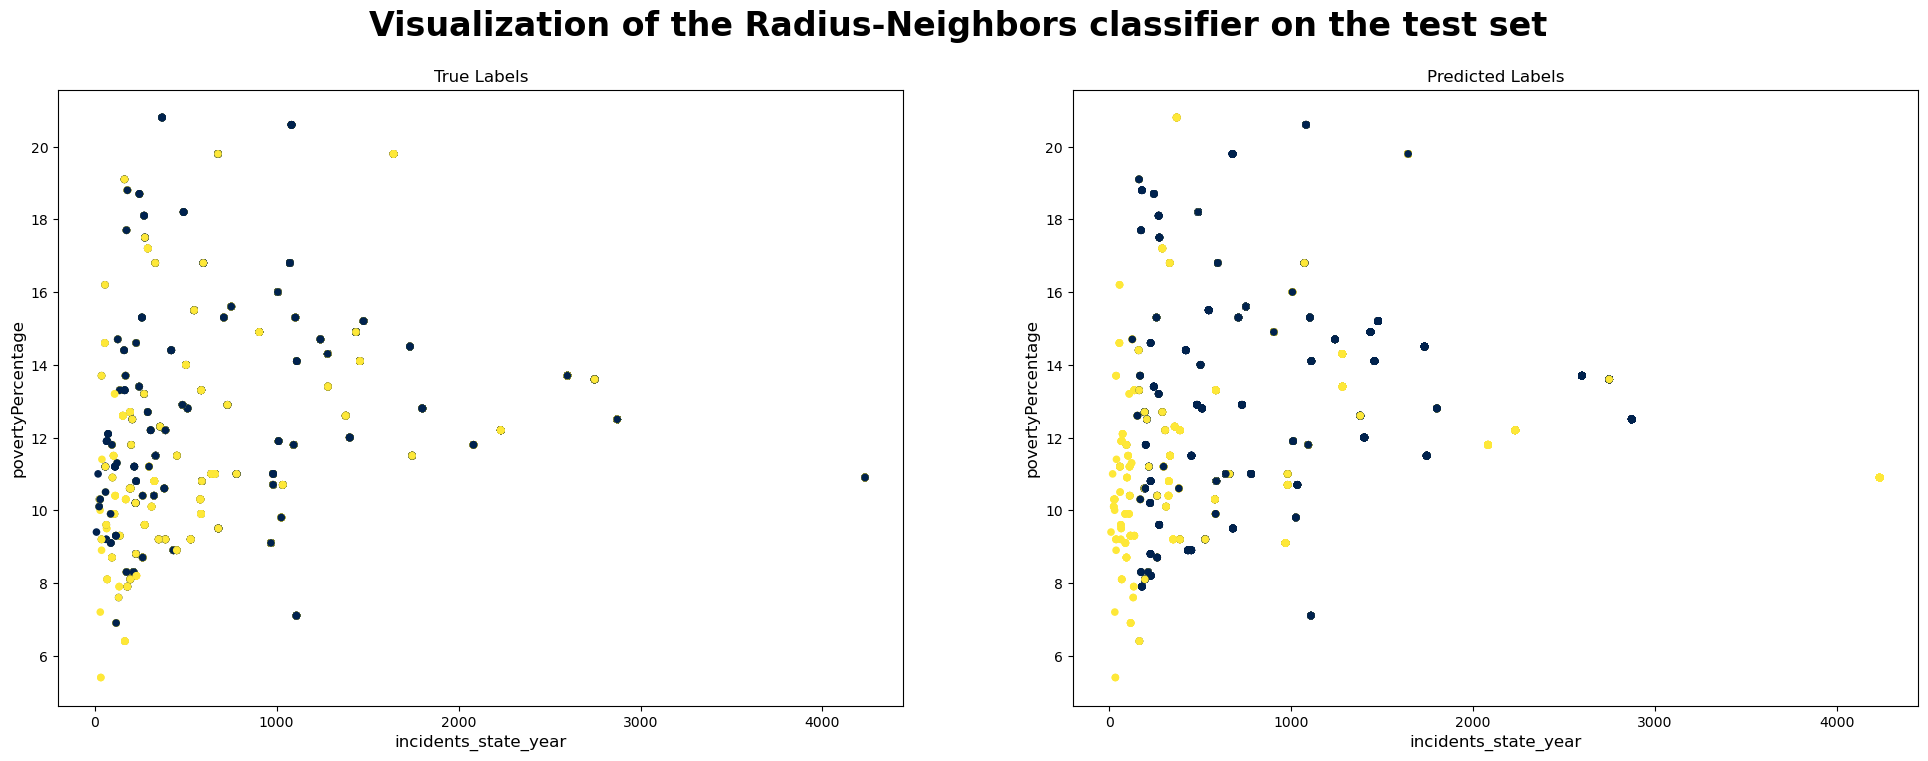

In [78]:
classification_visualizer(test_set, test_label, test_pred_radius, 'Radius-Neighbors')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that the raius classifier is quite good, but the previuous knn model performed better.

##### Confusion Matrix of the classifier

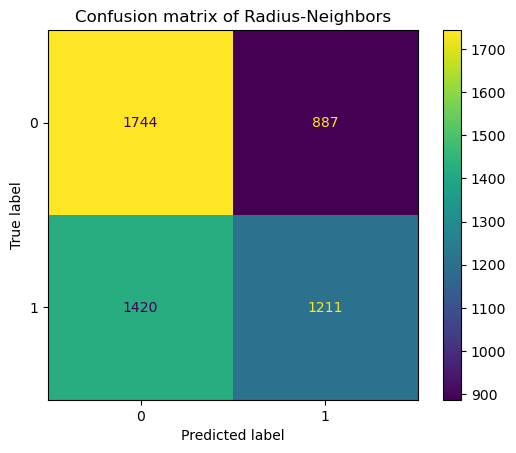

In [79]:
plot_c_matrix(test_set, test_label, test_pred_radius, radius, 'Radius-Neighbors')

Again, the class that got more errors is that of medium spending, erroneously classified most often as high spending.


##### ROC Curve of the classifier

In [80]:
test_pred_proba_radius = radius.predict_proba(test_set)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

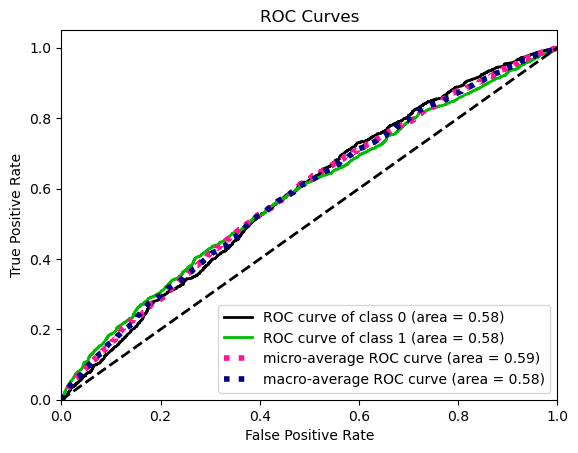

In [81]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_label, test_pred_proba_radius)

The graph above reflects the results shown so far. The concentration of points in the upper left area of the graph demonstrates a high sensitivity on the part of the classifier.

# ------------------------------

### Support Vector Machine

[Scikit Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is a model that select the **best decision boundary** to separate data. SVM represents the decision boundary using a subset of the training examples, known as the support vectors.

#### Import libraries

In [82]:
from sklearn.svm import SVC
from numpy.random import randint as sp_randint

#### Grid search 

Since this classifier has many parameters, a grid search is required.

However, we were unable to run the code written below and run it, as it is far too complex.

So we decided to fit two SVM models with two different kernel types: we focused our attention on the *kernel* parameter as it is what determines the shape of the decision boundaries.

In [83]:
'''
param_dist = {"kernel": ['rbf', 'sigmoid'], # fondamentale per plottare le regioni di piano
              "C": sp_randint(1, 10),
              "gamma": ["scale", "auto"], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              "probability": [True, False], # Whether to enable probability estimates. 
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 20
#define the model
clf = SVC()
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score), verbose=5)
#run the grid search
grid_search.fit(train_set, train_label)

print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])
'''

'\nparam_dist = {"kernel": [\'rbf\', \'sigmoid\'], # fondamentale per plottare le regioni di piano\n              "C": sp_randint(1, 10),\n              "gamma": ["scale", "auto"], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.\n              "probability": [True, False], # Whether to enable probability estimates. \n              "class_weight":[\'balanced\', None]}\n#define the number of iters\nn_iter_search = 20\n#define the model\nclf = SVC()\n#define the grid search\ngrid_search = RandomizedSearchCV(clf, param_distributions=param_dist, \n                            n_iter=n_iter_search, \n                            n_jobs=10, \n                            scoring=make_scorer(accuracy_score), verbose=5)\n#run the grid search\ngrid_search.fit(train_set, train_label)\n\nprint(\'Best setting parameters\n\', grid_search.cv_results_[\'params\'][0])\nprint(\'\nMean of this setting\n\', grid_search.cv_results_[\'mean_test_score\'][0], \n      \'\n\nStandard Deviation (std) of this 

N.B. 
- The C parameter in the model is a regularization parameter. The strength of the regularization is inversely proportional to C.
- The *gamma* parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The *gamma* parameter can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

#### Fitting and running the model

SVC implement the “one-versus-one” approach for multi-class classification. In total, *n_classes * (n_classes - 1) / 2* classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the *decision_function_shape* option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

In [84]:
svm = SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, decision_function_shape='ovo')

In [85]:
svm.fit(train_set, train_label)

SVC(C=0.5, decision_function_shape='ovo', probability=True)

In [86]:
svm_sigm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True, decision_function_shape='ovo')

In [87]:
svm_sigm.fit(train_set, train_label)

SVC(C=0.5, decision_function_shape='ovo', kernel='sigmoid', probability=True)

##### Training

In [88]:
train_pred_svm = svm.predict(train_set)
train_pred_svm_sigm = svm_sigm.predict(train_set)

##### Testing

In [89]:
test_pred_svm = svm.predict(test_set)
test_pred_svm_sigm = svm_sigm.predict(test_set)

##### Probabilities

Since we enabled probability estimates for the model (i.e. we set the *probability* parameter as True) we can visualize them.

In [90]:
test_pred_proba_svm = svm.predict_proba(test_set)

In [91]:
test_pred_proba_svm_sigm = svm_sigm.predict_proba(test_set)

#### Evaluation

##### Model performance on the training set (with rbf kernel)

In [92]:
print ('SVM with rbf kernel: \n')
print(classification_report(train_label, train_pred_svm, target_names=class_names))

SVM with rbf kernel: 

              precision    recall  f1-score   support

   No murder       0.52      0.78      0.62      6139
      Murder       0.56      0.28      0.37      6139

    accuracy                           0.53     12278
   macro avg       0.54      0.53      0.50     12278
weighted avg       0.54      0.53      0.50     12278



##### Model performance on the training set (with sigmoid kernel)

In [93]:
print ('SVM with sigmoid kernel: \n')
print(classification_report(train_label, train_pred_svm_sigm, target_names=class_names))

SVM with sigmoid kernel: 

              precision    recall  f1-score   support

   No murder       0.48      0.48      0.48      6139
      Murder       0.48      0.48      0.48      6139

    accuracy                           0.48     12278
   macro avg       0.48      0.48      0.48     12278
weighted avg       0.48      0.48      0.48     12278



##### Model performance on the test set (with rbf kernel)

In [94]:
print ('SVM with rbf kernel: \n')
print(classification_report(test_label, test_pred_svm, target_names=class_names))

SVM with rbf kernel: 

              precision    recall  f1-score   support

   No murder       0.52      0.78      0.62      2631
      Murder       0.56      0.28      0.37      2631

    accuracy                           0.53      5262
   macro avg       0.54      0.53      0.50      5262
weighted avg       0.54      0.53      0.50      5262



##### Model performance on the test set (with sigmoid kernel)

In [95]:
print ('SVM with sigmoid kernel: \n')
print(classification_report(test_label, test_pred_svm_sigm, target_names=class_names))

SVM with sigmoid kernel: 

              precision    recall  f1-score   support

   No murder       0.48      0.48      0.48      2631
      Murder       0.48      0.48      0.48      2631

    accuracy                           0.48      5262
   macro avg       0.48      0.48      0.48      5262
weighted avg       0.48      0.48      0.48      5262



It is easy to see that the performance of this model with *kernel = rbf* (Radial Basis Function) is terrible. In fact it is classifying all data points as murders. The SVM with *kernel = sigmoid* instead is working a little better, but is still working pretty bad on No Murder data points.

##### Visualization of the classifier results via scatterplots

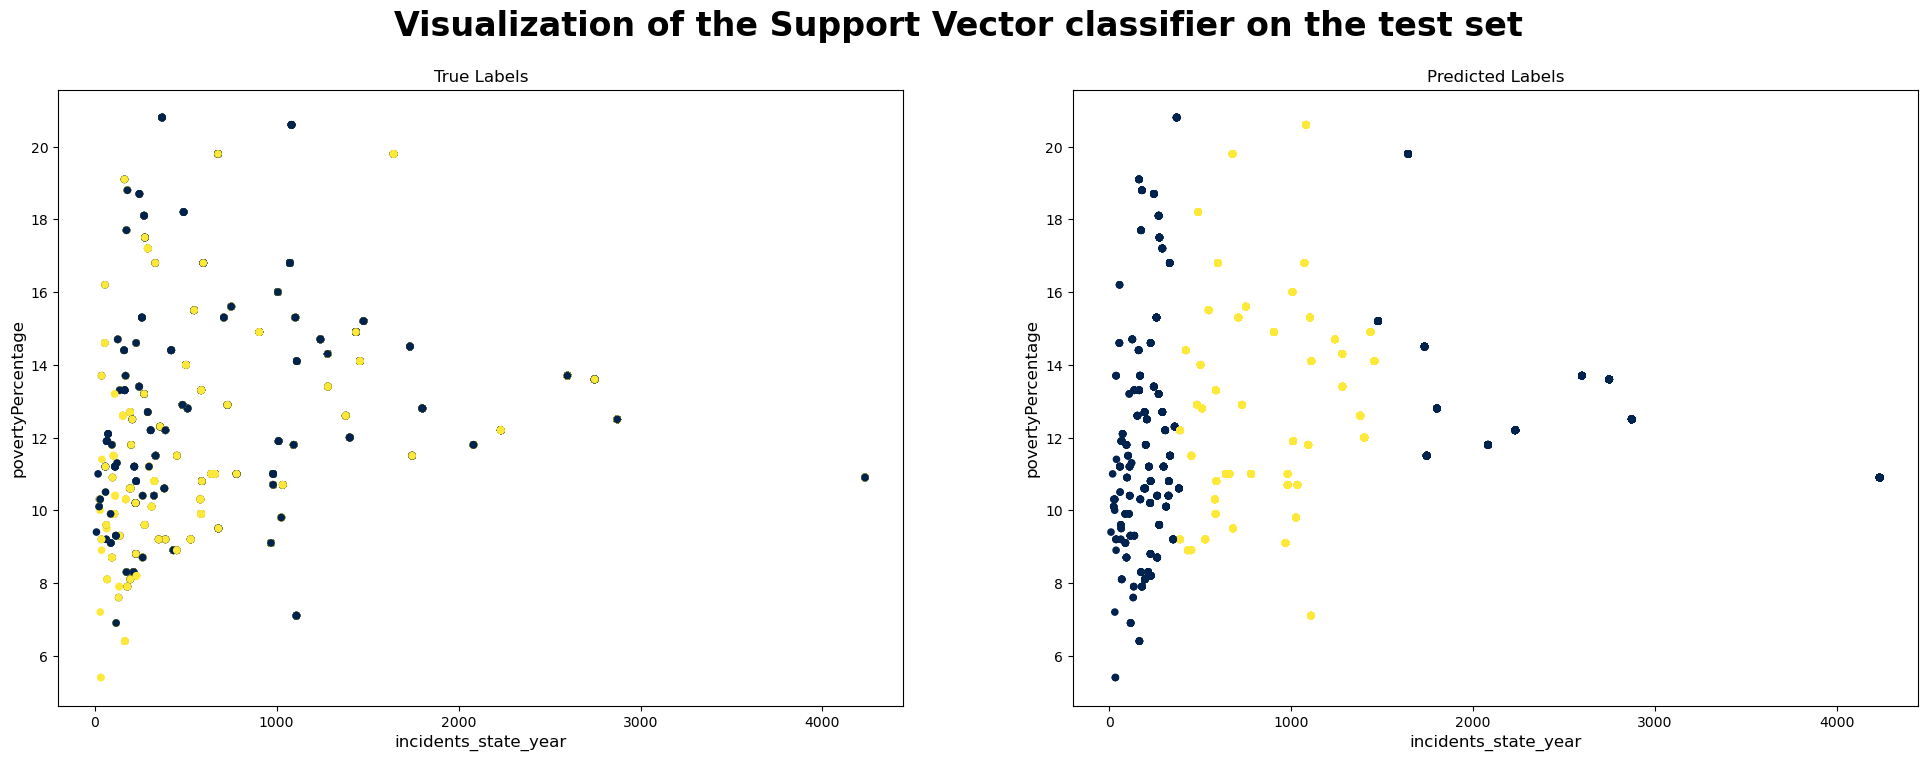

In [96]:
classification_visualizer(test_set, test_label, test_pred_svm_sigm, 'Support Vector')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that SVM classifier with sigmoid kernel is still working pretty bad for us.

##### Visualization of the decision boundary of the classifier

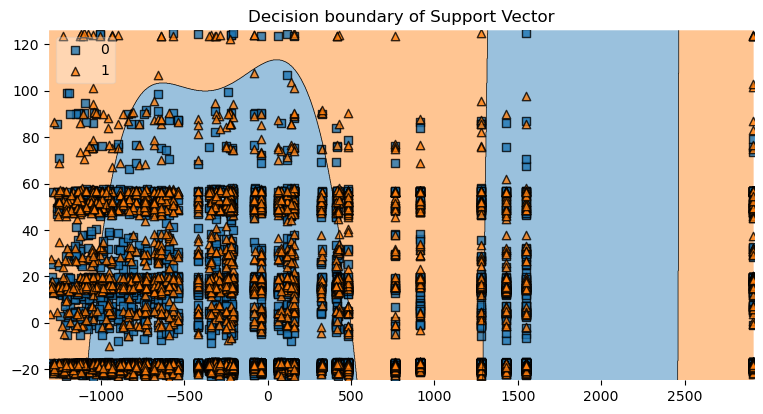

In [97]:
plot_decision_boundary(train_set, train_label, svm, 'Support Vector')

The decision boundaries drawn by this model for our data are quite precise: it must be said that they strongly depends on the type of kernel. 

Maybe, with the opportunity to run the grid search, we could have found even better configurations of parameter and so we could have obtained a better hyperplane to separate data into classes.

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

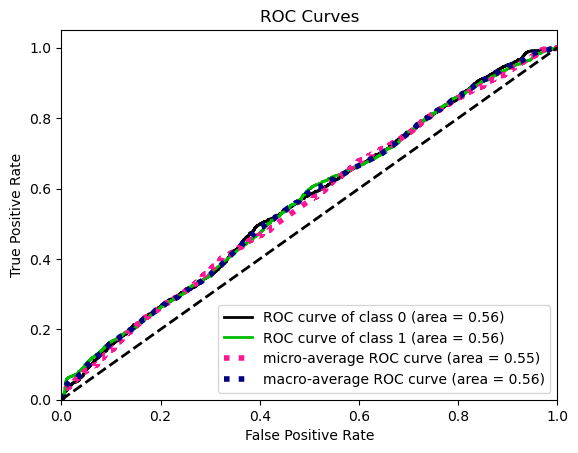

In [98]:
import scikitplot as skplt

skplt.metrics.plot_roc(test_label, test_pred_proba_svm)

#### Comments on SVM classifier 

The only obstacle we faced while running the model was the grid search. The excessive complexity did not allow us to compute the best configuration of parameters for this model.

However, SVM confirms to be as a very powerful model for data classification, even with high number of features and so high-dimensionality of the dataset.

##### Advantages

- Effective in high dimensional spaces.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- Versatile: different Kernel functions can be specified for the decision function. 

##### Disadvantages

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are computed using an expensive five-fold cross-validation.

# ------------------------------

## Neural Networks

We present here two different models based on Neural Networks:
- a **Feed-forward NN**, that we built using the Keras Classifier model, by adding different layers.
- a **Multi-layer perceptron**, a very famous ML model.

### Feed-forward Neural Network

A multi-layer neural network can solve any type of classification tasks.

In our case, we want the output layer to create 3 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

We use a *softmax* activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

#### Import libraries

In [99]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2024-01-08 15:37:53.316531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Grid search
In order to perform the grid search on our Neural Network we need the help of a model called Keras Classifier.

In [100]:
def baseline_model(optimizer = 'adam', init_mode='uniform', activation='relu', dropout_rate=0.2, neurons=8, loss='categorical_crossentropy'):
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [101]:
nn = KerasClassifier(build_fn=baseline_model, verbose=0)

/tmp/ipykernel_175933/3178602217.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=baseline_model, verbose=0)


In [102]:
from scipy.stats import uniform
from scipy.stats import randint

batch_size = [500]
epochs = [100]
optimizer = ['SGD', 'adam', 'adamax'] 
activation = ['softmax', 'relu', 'sigmoid', 'linear']
dropout_rate = [0.2]
neurons = randint(5, 20)
loss = ['binary_crossentropy', 'mean_squared_error', 'categorical_crossentropy']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, 
                  activation=activation, dropout_rate=dropout_rate, neurons=neurons, loss=loss) 

grid = RandomizedSearchCV(estimator=nn, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=3, verbose=5)
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
grid_result = grid.fit(train_set, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-01-08 15:37:55.183021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 15:37:55.194363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 15:37:55.220795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08

[CV 2/3] END activation=relu, batch_size=500, dropout_rate=0.2, epochs=100, loss=binary_crossentropy, neurons=6, optimizer=SGD;, score=nan total time=   0.4s
[CV 1/3] END activation=relu, batch_size=500, dropout_rate=0.2, epochs=100, loss=binary_crossentropy, neurons=6, optimizer=SGD;, score=nan total time=   0.4s
[CV 3/3] END activation=relu, batch_size=500, dropout_rate=0.2, epochs=100, loss=binary_crossentropy, neurons=6, optimizer=SGD;, score=nan total time=   0.3s
[CV 3/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=19, optimizer=adam;, score=nan total time=   0.3s
[CV 1/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=19, optimizer=adam;, score=nan total time=   0.3s
[CV 1/3] END activation=sigmoid, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=5, optimizer=adam;, score=nan total time=   0.3s
[CV 2/3] END activation=l

2024-01-08 15:37:57.680523: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 28. Tune using inter_op_parallelism_threads for best performance.



[CV 3/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=11, optimizer=adamax;, score=nan total time=   0.1s
[CV 1/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=11, optimizer=adamax;, score=nan total time=   0.1s
[CV 2/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=11, optimizer=adamax;, score=nan total time=   0.1s
[CV 2/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=16, optimizer=adam;, score=nan total time=   0.2s
[CV 3/3] END activation=linear, batch_size=500, dropout_rate=0.2, epochs=100, loss=categorical_crossentropy, neurons=16, optimizer=adam;, score=nan total time=   0.2s
[CV 1/3] END activation=relu, batch_size=500, dropout_rate=0.2, epochs=100, loss=binary_crossentropy, neurons=19, optimizer=adam;, score=nan total time=   0.2

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
192 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lospiri/anaconda3/envs/data_mining/

In [103]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.602208 using {'activation': 'linear', 'batch_size': 500, 'dropout_rate': 0.2, 'epochs': 100, 'loss': 'mean_squared_error', 'neurons': 7, 'optimizer': 'adam'}


#### Run again the NN with the best configuration of parameters for 9 neurons 

In [104]:
def baseline_model(optimizer = 'adamax', init_mode='uniform', activation='sigmoid', dropout_rate=0.2, neurons=15, loss='mean_squared_error'): #specify parameters so that we can do grid search
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [105]:
nn = KerasClassifier(build_fn=baseline_model, verbose=0)

/tmp/ipykernel_175933/3178602217.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=baseline_model, verbose=0)


In [106]:
history = nn.fit(train_set.values, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.2)

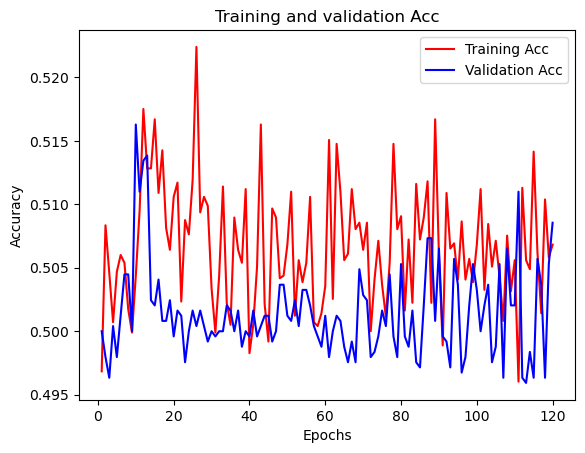

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training Acc', c='r')
plt.plot(epochs, val_acc, label='Validation Acc', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the curve we can observe how the accuracy improves both for training and for the test set, even if its zig-zag behavior suggests that the learning is good but not optimal.

In [108]:
test_pred_nn = nn.predict(test_set)

165/165 [==============================] - 0s 690us/step


##### Model performance on the test set

In [109]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

           0       0.53      0.24      0.33      2631
           1       0.51      0.79      0.62      2631

    accuracy                           0.51      5262
   macro avg       0.52      0.51      0.47      5262
weighted avg       0.52      0.51      0.47      5262



The accuracy of the model is good and, again, the classes that confirm to have the best values of the other metrics are low-spending and high-spending

##### Visualization of the classifier results via scatterplots

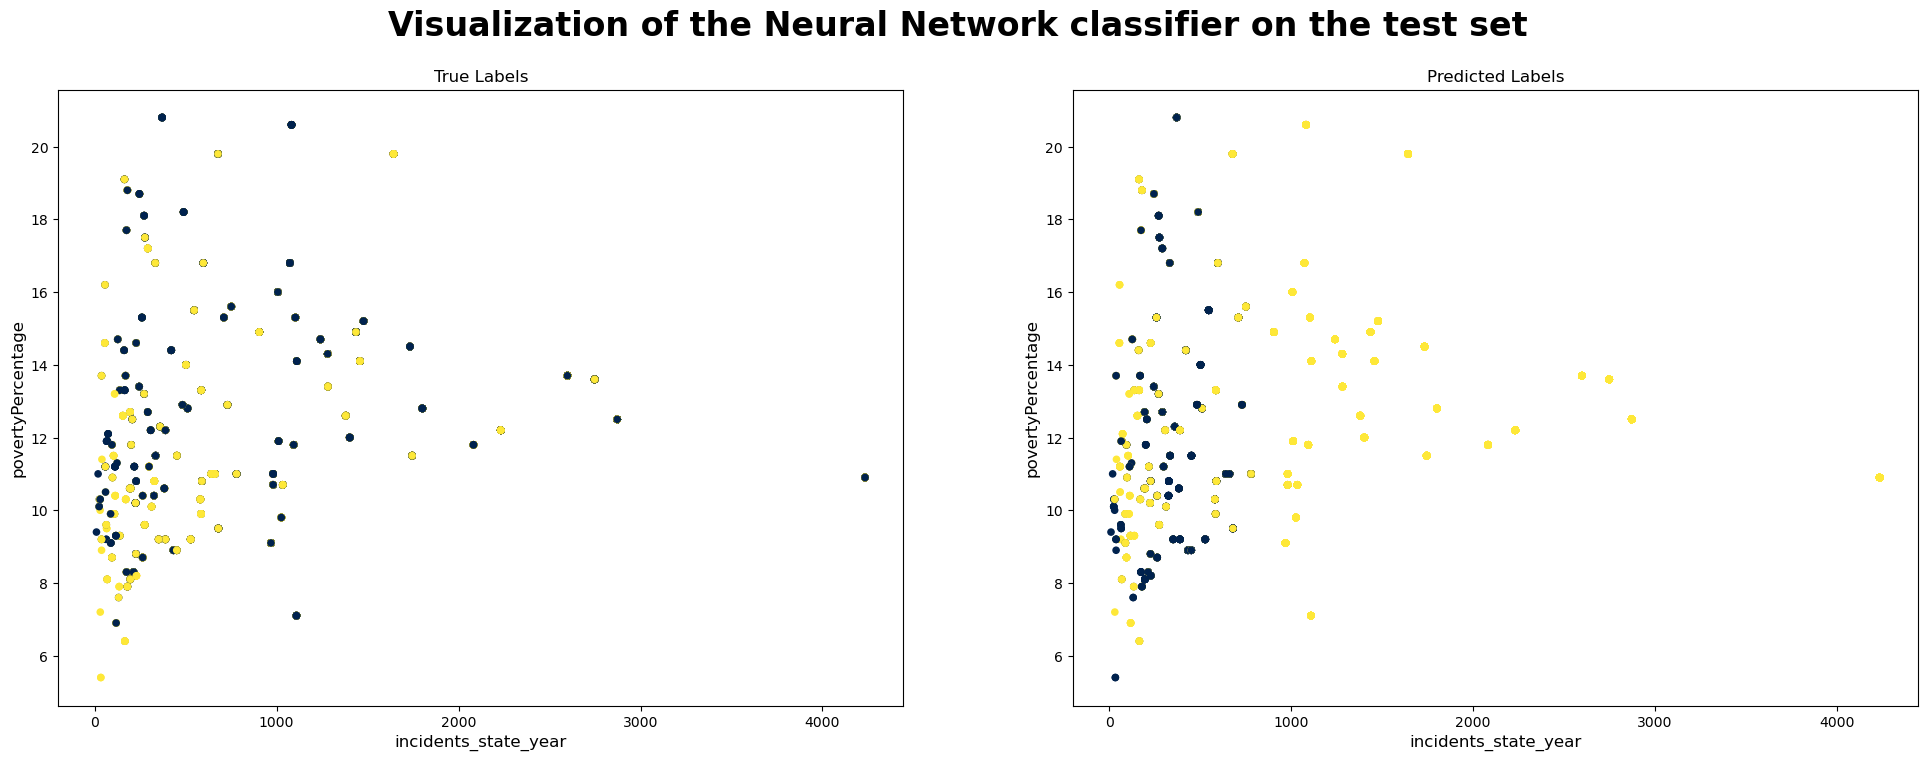

In [110]:
classification_visualizer(test_set, test_label, test_pred_nn, 'Neural Network')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that the Feed-forward NN is quite accurate as it did not make excessive errors in the prediction.

##### Confusion Matrix of the classifier

Unfortunately we cannot plot the confusion matrix for the Keras Classifiers, because this option is not supported by this model.

##### Visualization of the decision boundary of the classifier

62500/62500 [==============================] - 64s 1ms/step


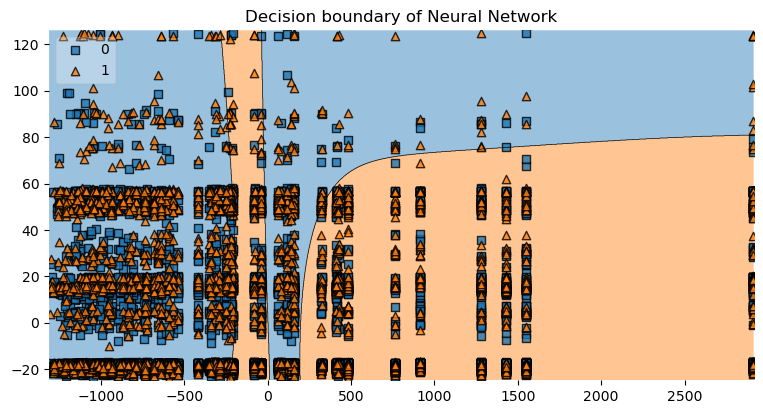

In [111]:
plot_decision_boundary(train_set, train_label, nn, 'Neural Network')

The decision boundaries drawn by this model for our data are very precise: in fact we know from the literature that Neural Networks are really powerful model for classification (and not only) and so even a really simple feed-forward one is able to find satisfying hyperplane to separate data.

### Multi-layer Perceptron
[Scikit MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. Is one of the (supervised) Neural network models of scikit-learn.

#### How the algorithm works
MLP is a supervised learning algorithm that learns a function $f(\cdot): R^m \rightarrow R^o$
by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = x_1, x_2, ..., x_m$
and a target $y$, it can learn a non-linear function approximator for classification. 

#### Import libraries

In [112]:
from sklearn.neural_network import MLPClassifier

#### Pre-processing
Multi-layer Perceptron is sensitive to feature scaling, so we have to scale our data. In this case we use StandardScaler for standardization.

It is important to apply the same scaling to the test set for meaningful results. 


In [113]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler()  
X_train = train_set
scaler.fit(X_train)  
X_train = scaler.transform(X_train)

X_test = test_set
X_test = scaler.transform(X_test)  

#### Grid search

In [114]:
parameter_space = {
    'hidden_layer_sizes': [100, 200],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.01],
    'learning_rate': ['constant','adaptive', 'invscaling']
}

estimator = MLPClassifier(random_state=1, max_iter=100)

grid = GridSearchCV(estimator=estimator, param_grid=parameter_space, n_jobs=-1)
grid_result = grid.fit(X_train, train_label)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization has

In [115]:
print('Best setting parameters\n', grid.cv_results_['params'][0])
print('\nMean of this setting\n', grid.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_result.cv_results_['std_test_score'][0])

Best setting parameters
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'sgd'}

Mean of this setting
 0.8514409866190782 

Standard Deviation (std) of this setting
 0.006241486187510464


#### Fitting and running the model

In [116]:
mlp = MLPClassifier(random_state=1, max_iter=300, activation='tanh', alpha=0.0001)
mlp.fit(X_train, train_label)

MLPClassifier(activation='tanh', max_iter=300, random_state=1)

In this case the prediction must be done on the normalized train and test set.

##### Training

In [117]:
train_pred_mlp = mlp.predict(X_train)

##### Testing

In [118]:
test_pred_mlp = mlp.predict(X_test)

##### Probabilities

In [119]:
test_pred_proba_mlp = mlp.predict_proba(X_test)
test_pred_proba_mlp

array([[9.99983749e-01, 1.62510043e-05],
       [9.86857436e-01, 1.31425642e-02],
       [9.99989562e-01, 1.04381808e-05],
       ...,
       [1.59146044e-02, 9.84085396e-01],
       [9.90027961e-01, 9.97203903e-03],
       [9.82797408e-01, 1.72025918e-02]])

#### Evaluation

##### Model performance on the training set

In [120]:
print ('Model performance on train set: \n')
report_scores(train_label, train_pred_mlp)

Model performance on train set: 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6139
           1       0.99      0.96      0.98      6139

    accuracy                           0.98     12278
   macro avg       0.98      0.98      0.98     12278
weighted avg       0.98      0.98      0.98     12278



##### Model performance on the test set

In [121]:
print ('Model performance on test set: \n')
report_scores(test_label, test_pred_mlp)

Model performance on test set: 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2631
           1       0.99      0.96      0.98      2631

    accuracy                           0.98      5262
   macro avg       0.98      0.98      0.98      5262
weighted avg       0.98      0.98      0.98      5262



We can see from the results that this is a very powerful model, able to return good performances even for complex data contexts.

##### Visualization of the classifier results via scatterplots

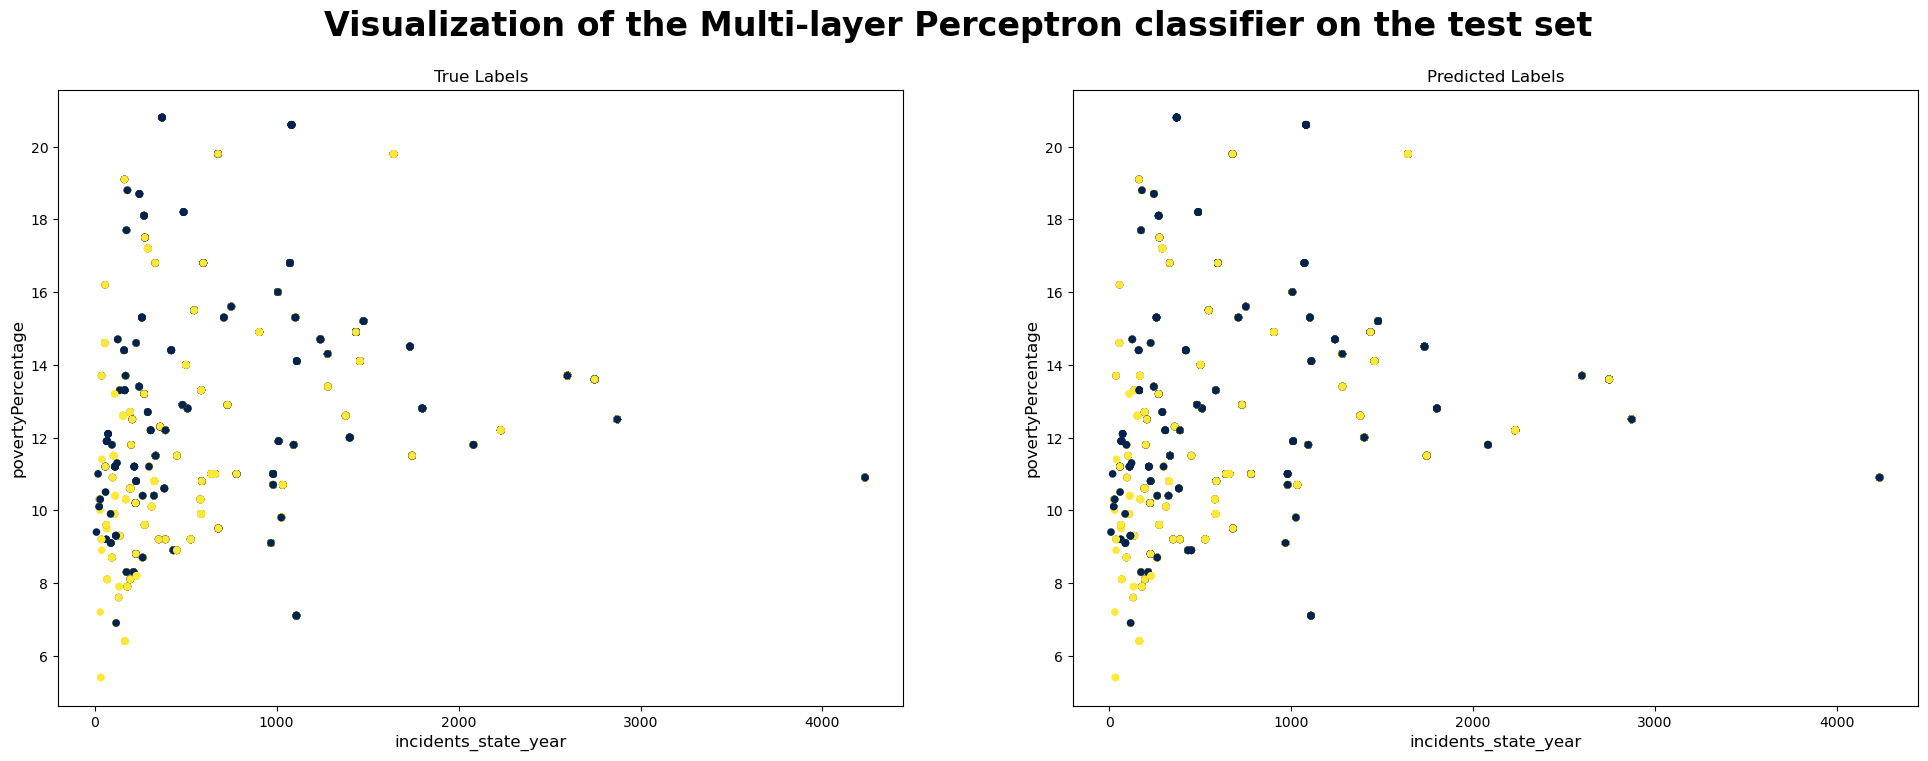

In [122]:
classification_visualizer(test_set, test_label, test_pred_mlp, 'Multi-layer Perceptron')

The misclassified points are very few: the fact that the prediction is really accurate confirms the power of this model.

##### Visualization of the decision boundary of the classifier

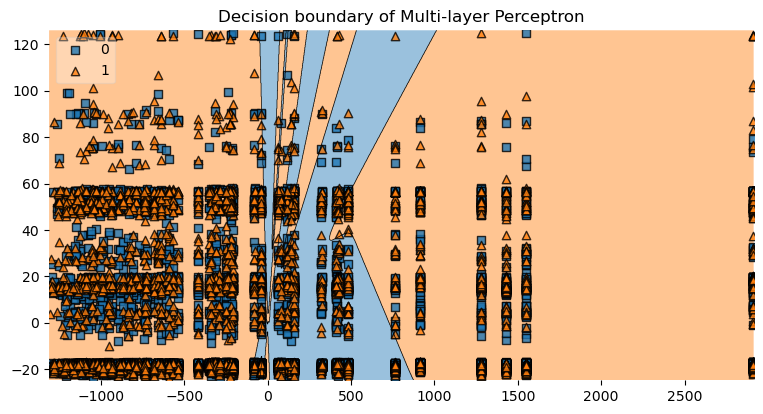

In [123]:
plot_decision_boundary(train_set, train_label, mlp, 'Multi-layer Perceptron')

Decision boundaries for this model are not so easy to interpret. It is not easy to see from this plot if they are accurate.

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

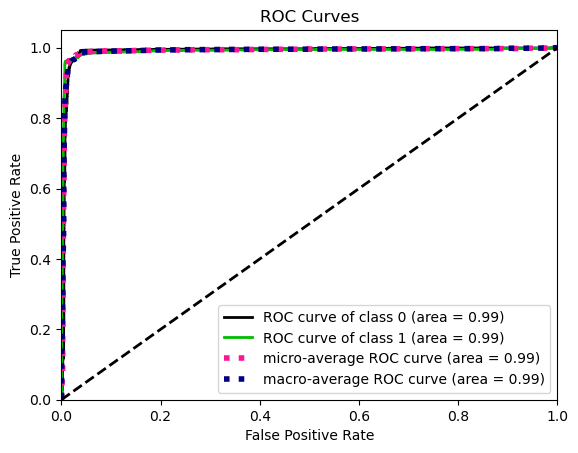

In [124]:
skplt.metrics.plot_roc(test_label, test_pred_proba_mlp)

The graph in question represents the high sensitivity, and therefore the low propensity to false positive classifications, of the neural network towards the dataset under analysis.

#### Comments on MLP classifier
One of the most important advantages of Multi-layer Perceptron is the capability to learn non-linear models. However, it has also some disadvantages to take into consideration:
- different random weight initializations can lead to different validation accuracy
- it requires tuning a lot of hyperparameters: grid-search process can be very time-consuming
- it is sensitive to feature scaling: for this reason, a pre-processing phase is needed.

##### Comments on optimizers for MLP
We know from literature that, for relatively large datasets, *Adam* is very robust. It usually converges quickly and gives pretty good performance. *SGD* with momentum or nesterov’s momentum, on the other hand, can perform better if learning rate is correctly tuned.

# ------------------------------

### Classification with Naive Bayes
This approach is one of the simplest, fastest and most popular classification techniques.

It is called "naive" because the starting hypotheses are very simplified. In fact, the algorithm has as premise a simplifying assumption: it considers the features of the model to be **independent from each other.**
Although this is useful for the application of the algorithm and for learning, we know that this assumption is not always representative of reality: in the real world the features of the data are often dependent and correlated.

#### How the algorithm works
Naive Bayes is a classification algorithm based on the application of **Bayes Theorem:**


$P(C|E) = \frac{P(E | C) P(C)}{P(E)} $

Where:
* $C$ denotes a class variable.
* $E$ is the evidence (i.e. the distribution of the sets of attributes), so the informations we derived from data.
* $P(C)$ is the prior probability of $C$ (does not take into account any information about $E$).
* $P(E)$ is the prior probability of the evidence $E$, and it acts as normalising constant.
* $P(C|E)$ is the conditioned probability of $C$, given the evidence $E$, aka **posterior probability**. It represents the probability of being assigned to the class $C$, knowing the distribution of attributes (i.e. knowing the evidence).
* $P(E|C)$ is the **likelihood**, so what we want to maximize. It represents the conditioned probability of $E$, given the evidence $C$


It is clear from this definition that Bayes theorem combines a **prior probability** with **knowledge deriving from data** (the evidence).

So since Naive Bayes classifiers is a based on a probabilistic approach, it provides a probability to be classified, i.e. the probability for each data point to belong to a certain class. Its aim is to **learn the posterior probability**, i.e. maximize the likelihood.

The algorithm computes all the posterior probabilities and it **chooses the label with the higher probability.**


### Gaussian Naive Bayes
[Scikit GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian. By assuming the data to have a Gaussian distribution, we can estimate the parameter for this distribution (that are mean $\mu$ and variance $\sigma$) using maximum likelihood.

Since we aren't going to specify prior probabilities of the classes (because we want them to be adjusted according to the data) grid search for GNB model is not needed.


#### Import libraries

In [125]:
from sklearn.naive_bayes import GaussianNB

#### Fitting and testing the model

In [126]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [127]:
train_pred_gnb = gnb.predict(train_set)

In [128]:
test_pred_gnb = gnb.predict(test_set)

#### Probabilities

Since we have said that Naive Bayes Classifier assigns a probability for each data point to belong to a certain class, here you can clearly see those probabilities, estimated for the test set:

In [129]:
test_pred_proba_gnb = gnb.predict_proba(test_set)
test_pred_proba_gnb

array([[0.17990135, 0.82009865],
       [0.94082501, 0.05917499],
       [0.82446724, 0.17553276],
       ...,
       [0.61805349, 0.38194651],
       [0.83018489, 0.16981511],
       [0.18690814, 0.81309186]])

#### Evaluation

##### Model performance on the training set

In [130]:
print ('GNB performance on train set: \n')
report_scores(train_label, train_pred_gnb)

GNB performance on train set: 

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      6139
           1       0.75      0.66      0.70      6139

    accuracy                           0.72     12278
   macro avg       0.72      0.72      0.72     12278
weighted avg       0.72      0.72      0.72     12278



##### Model performance on the test set

In [131]:
print ('GNB performance on test set: \n')
report_scores(test_label,test_pred_gnb)

GNB performance on test set: 

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      2631
           1       0.74      0.64      0.69      2631

    accuracy                           0.71      5262
   macro avg       0.71      0.71      0.71      5262
weighted avg       0.71      0.71      0.71      5262



It can be easily understood from the performance of the model that the results are not bad. Our dataset is quite complex but it is not unexpected that its data follows a gaussian distribution.

##### Model performance on the training set

In [132]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_gnb))
print('Precision train set ', metrics.precision_score(train_label, train_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_gnb))

Accuracy train set  0.7174621273823099
Precision train set  0.7206596717392008
Recall train set  0.7174621273823099
F1 score train set  0.7164348529731029
Support train set  (array([0.69409712, 0.74722222]), array([0.77765108, 0.65727317]), array([0.73350234, 0.69936736]), array([6139, 6139]))


##### Model performance on the test set

In [133]:
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision test set ', metrics.precision_score(test_label, test_pred_gnb, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_gnb, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_gnb, average='weighted'))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_gnb))

Accuracy test set  0.70961611554542
Precision test set  0.7139865074618941
Recall test set  0.70961611554542
F1 score test set  0.7081258293925916
Support test set  (array([0.68340539, 0.74456763]), array([0.78107184, 0.6381604 ]), array([0.72898191, 0.68726975]), array([2631, 2631]))


##### Visualization of the classifier results via scatterplots
Here you can clearly see the true test labels, the prediction made by the Gaussian Naive Bayes classfier and the misclassified points (i.e. the errors that the model made).

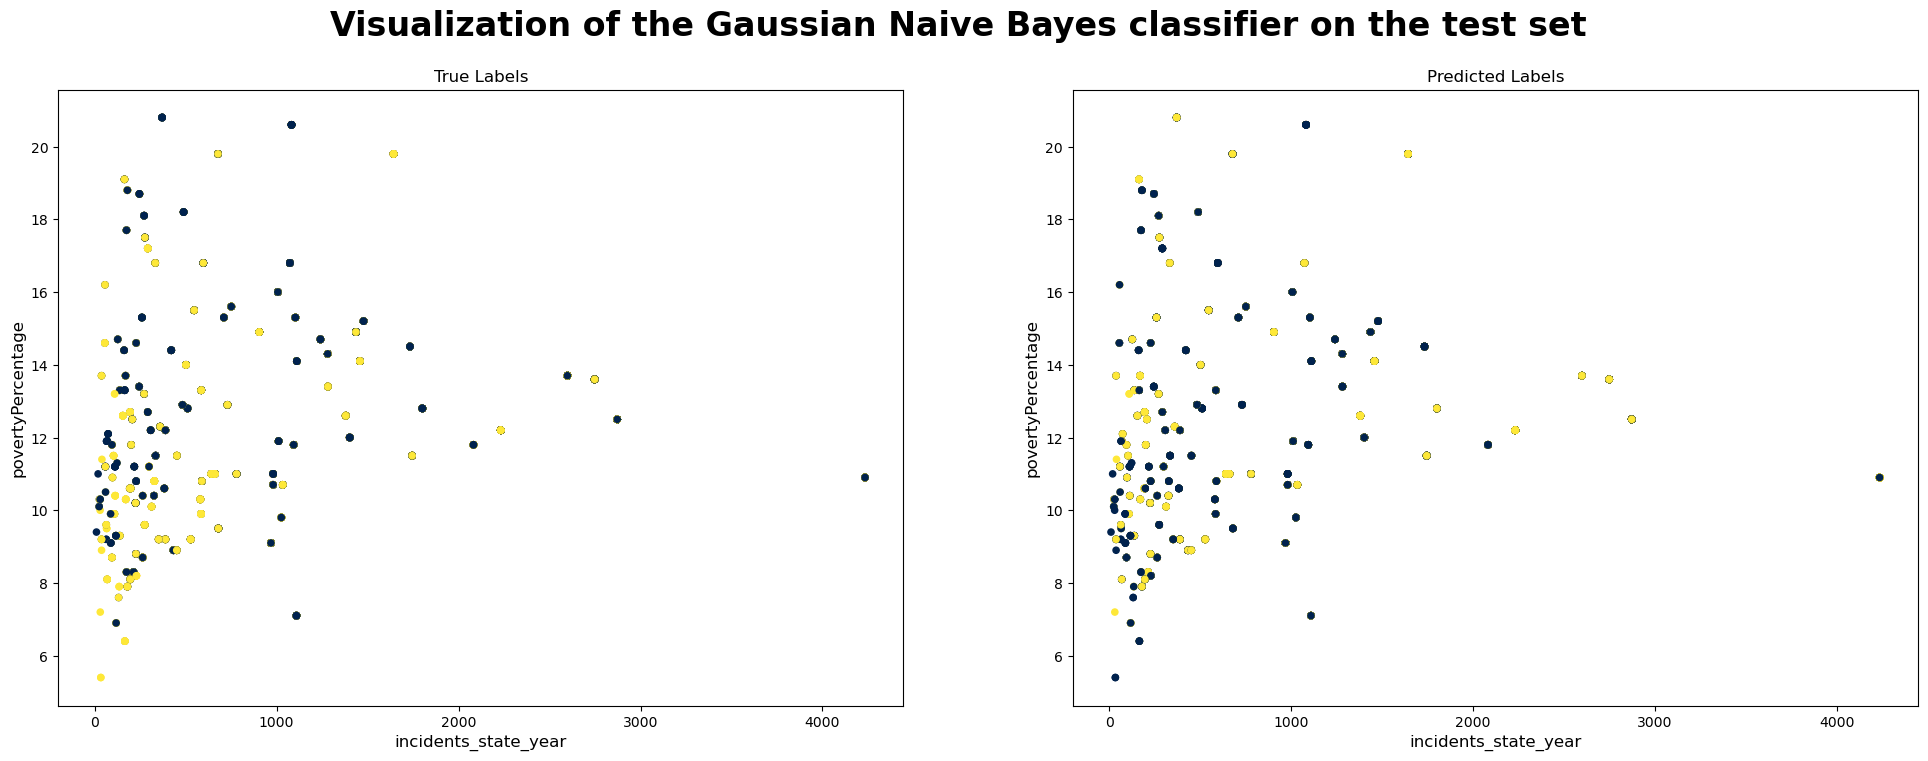

In [134]:
classification_visualizer(test_set, test_label, test_pred_gnb, 'Gaussian Naive Bayes')

##### Confusion Matrix of the classifier

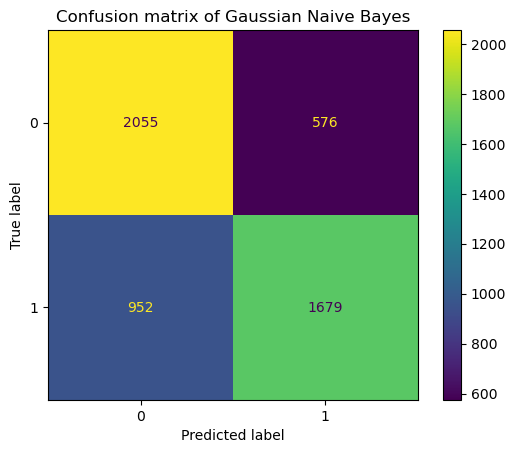

In [135]:
plot_c_matrix(test_set, test_label, test_pred_gnb, gnb, 'Gaussian Naive Bayes')

Again, the class that reports more errors is that of No Murder.

##### Visualization of the decision boundary of the classifier

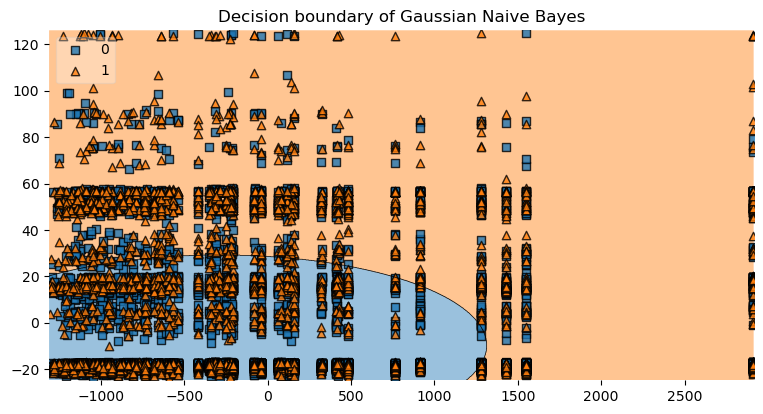

In [136]:
plot_decision_boundary(train_set, train_label, gnb, 'Gaussian Naive Bayes')

The decision boundaries drawn by this model for our data are **elliptic**: this confirms what was previously said about the **excessive simplicity of this model, which is not able to fit complex data like ours**.

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

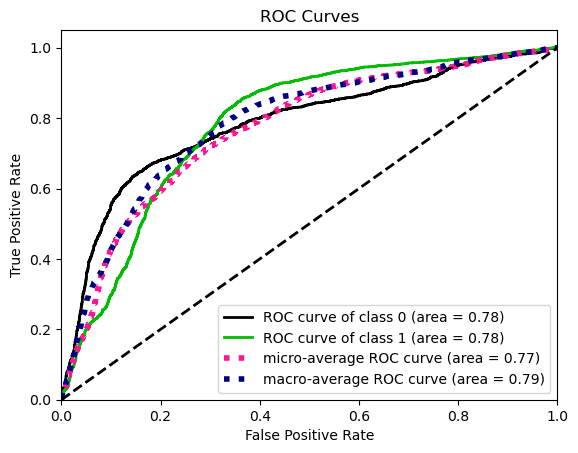

In [137]:
skplt.metrics.plot_roc(test_label, test_pred_proba_gnb)

# ------------------------------

### Multinomial Naive Bayes
[Scikit MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) implements the naive Bayes algorithm for multinomially distributed data. It is often used in text classification.

The distribution is parametrized by vectors $\theta_c = (\theta_{c1}, ..., \theta_{cn})$
for each class $c$, where $n$ is the number of features and $\theta_{ci}$ is the probability $P(x_i | c)$
of feature $i$ belonging to class $c$ .

The parameters $\theta_c$ is estimated by a smoothed version of maximum likelihood.

#### Laplacian Estimator

We have seen during lectures that, in the Naive Bayes classifiers, if one of the conditional probability is zero, the entire expression becomes zero. In order to prevent that, we can use the Laplacian estimator (like in rule-based classifiers).

The smoothing priors $\alpha \geq 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha =1 $ is called Laplace smoothing, while $\alpha <1$ is called Lidstone smoothing.


#### Import libraries

In [138]:
from sklearn.naive_bayes import MultinomialNB

#### Grid Search
Since we want to find the best value of the $\alpha$ parameter for this model, we think that a (brief) grid search is needed.

In [139]:
param_dist = {
    "alpha": [0,1,2,3,5,6,7,8,9]
} 
              
n_iter_search = 50
clf = MultinomialNB() # The number of trees in the forest
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manual

RandomizedSearchCV(estimator=MultinomialNB(), n_iter=50, n_jobs=10,
                   param_distributions={'alpha': [0, 1, 2, 3, 5, 6, 7, 8, 9]},
                   scoring=make_scorer(accuracy_score))

Print the best set of hyperparameters for this dataset.

In [140]:
print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'alpha': 0}

Mean of this setting
 0.5302967751779589 

Standard Deviation (std) of this setting
 0.008523184306015426


#### Fitting and testing the model

In [141]:
mnb = MultinomialNB(alpha=0)
mnb.fit(train_set, train_label)

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


MultinomialNB(alpha=0)

In [142]:
train_pred_mnb = mnb.predict(train_set)
train_pred_mnb

array([1, 0, 0, ..., 0, 0, 0])

In [143]:
test_pred_mnb = mnb.predict(test_set)
test_pred_mnb

array([1, 0, 0, ..., 1, 1, 1])

In [144]:
mnb.get_params()

{'alpha': 0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

#### Probabilities

Since we have said that Naive Bayes Classifier assigns a probability for each data point to belong to a certain class, here you can clearly see those probabilities, estimated for the test set:

In [145]:
test_pred_proba_mnb = mnb.predict_proba(test_set)
test_pred_proba_mnb

array([[2.60917379e-03, 9.97390826e-01],
       [9.99843420e-01, 1.56579837e-04],
       [9.99940936e-01, 5.90642062e-05],
       ...,
       [2.79848848e-01, 7.20151152e-01],
       [8.63322035e-02, 9.13667796e-01],
       [3.01423892e-12, 1.00000000e+00]])

#### Evaluation

##### Model performance on the training set

In [146]:
print ('GNB performance on train set: \n')
report_scores(train_label,train_pred_mnb)

GNB performance on train set: 

              precision    recall  f1-score   support

           0       0.53      0.63      0.57      6139
           1       0.54      0.43      0.48      6139

    accuracy                           0.53     12278
   macro avg       0.53      0.53      0.53     12278
weighted avg       0.53      0.53      0.53     12278



##### Model performance on the test set

In [147]:
print ('GNB performance on test set: \n')
report_scores(test_label,test_pred_mnb)

GNB performance on test set: 

              precision    recall  f1-score   support

           0       0.53      0.63      0.58      2631
           1       0.54      0.43      0.48      2631

    accuracy                           0.53      5262
   macro avg       0.54      0.53      0.53      5262
weighted avg       0.54      0.53      0.53      5262



The performance of this model confirms what has been said above for Gaussian classifier: since they are very simple models, they do not perform optimally on our data and this justifies the obtained results.

We will see later that more complex models have better results on our dataset.

##### Visualization of the classifier results via scatterplots
Here you can clearly see the true test labels, the prediction made by the Multinomial Naive Bayes classfier and the misclassified points (i.e. the errors that the model made).

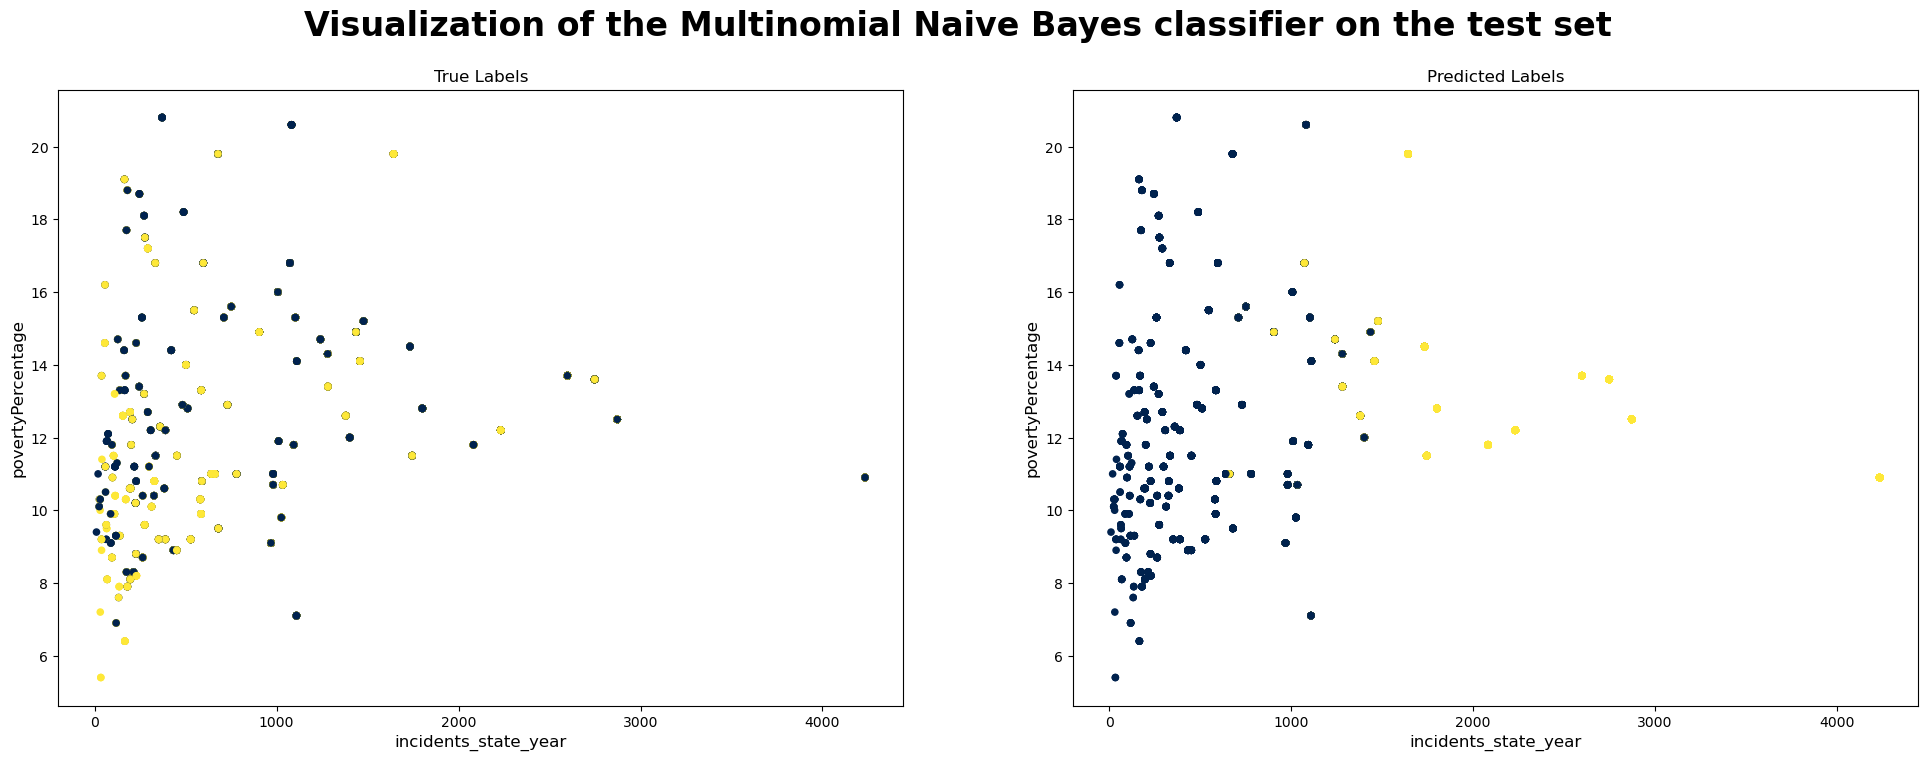

In [148]:
classification_visualizer(test_set, test_label, test_pred_mnb, 'Multinomial Naive Bayes')

##### Confusion Matrix of the classifier

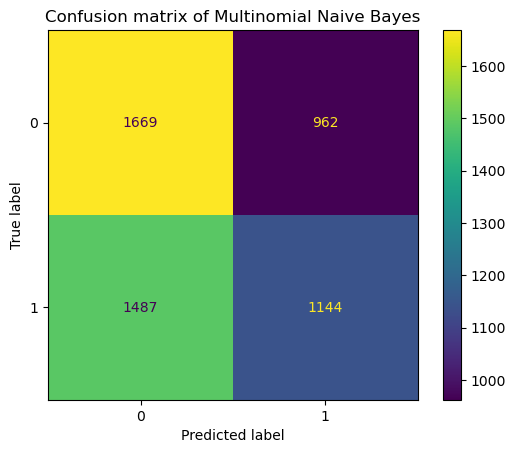

In [149]:
plot_c_matrix(test_set, test_label, test_pred_mnb, mnb, 'Multinomial Naive Bayes')

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

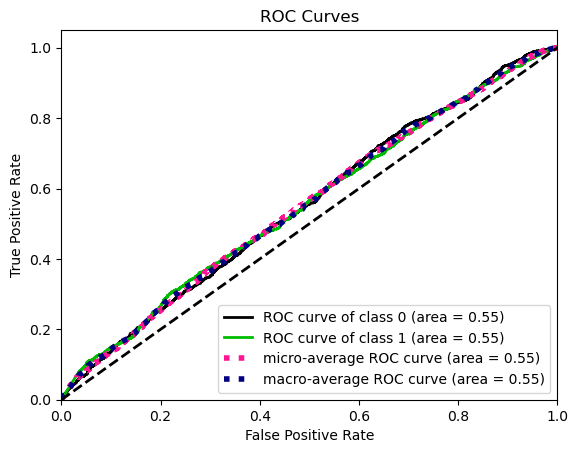

In [150]:
skplt.metrics.plot_roc(test_label, test_pred_proba_mnb)

Once again the plot displays the below-average performance of the classifier regarding the classification of medium-spending customers.

#### Naive Bayes final considerations 

Naive Bayes classifiers are certainly not the best for this type of data and features: in fact they are too simple models and they cannot perform well.

##### Pros
- Robust to isolated noise points
- Handle missing values by ignoring the instance during probability estimate calculations
- Robust to irrelevant attributes (because it follows a probabilistic approach)

It must be said that, in this context, these advantages do not have much relevance: in fact, our dataset has already been deeply cleaned up during Task 1, and it is therefore already free of outliers, noise and missing values.

##### Cons
- Independence assumption may not hold for some attributes

In our case, the problem of highly correlated features does not arise as they have already been eliminated during the preprocessing of Task 2.

# ------------------------------

### Decision Tree
A non-parametric supervised learning method used for classification and regression.
The deeper the tree, the more complex the decision rules and the fitter the model.

scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.

#### Import libraries

In [151]:
from sklearn import tree
from scipy.stats import randint

#### Pre-processing

Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.

Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to. Use max_depth to control the size of the tree to prevent overfitting.

Use min_samples_split or min_samples_leaf to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data
For classification with few classes, min_samples_leaf=1 is often the best choice.


#### Grid search
Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

In [152]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [153]:
dt_max_depth = [2,3,5,6,7,10,12, None]
dt_min_samples_split = randint(2, 51)
min_samples_leaf = randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features
            }

In [154]:
n_iter_search = 50
n_jobs_search = -1

In [155]:
dt_grid = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=dt_param_grid, 
                            n_iter=n_iter_search,  
                            n_jobs=n_jobs_search,
                            scoring=make_scorer(accuracy_score))

In [156]:
dt_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': [None, 2, 3, 4, 5],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbdbc247a10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbdbc2702d0>,
                                        'splitter': ['best', 'random']},
                   scoring=make_scorer(accuracy_score))

In [157]:
print(dt_grid.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 28, 'splitter': 'best'}


In [158]:
dt = tree.DecisionTreeClassifier(**dt_grid.best_params_).fit(train_set, train_label)

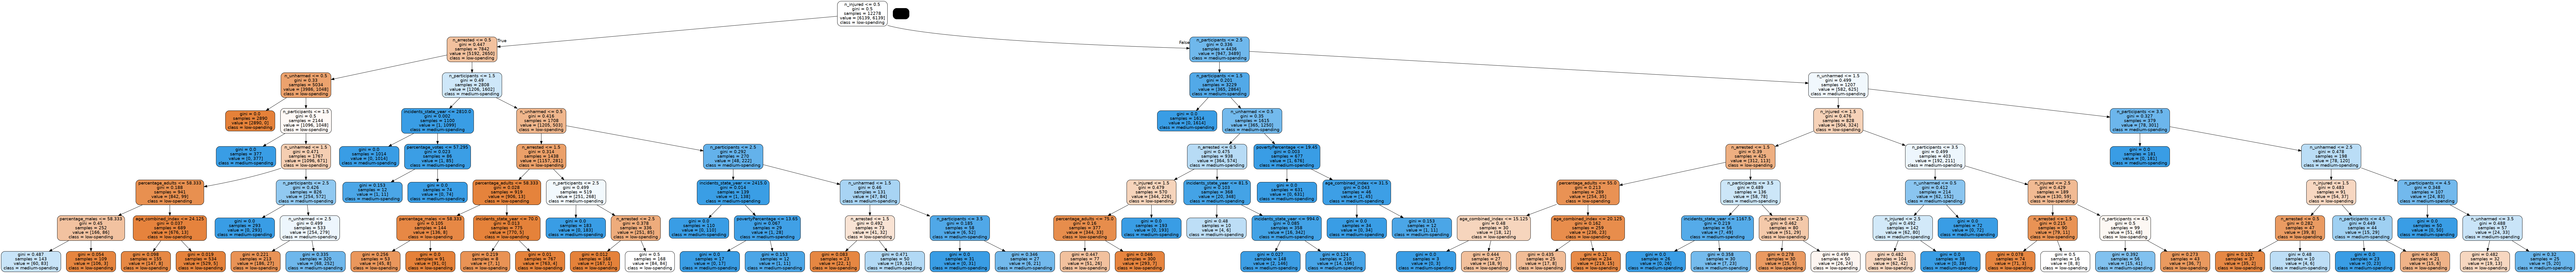

In [159]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image 
class_names=['low-spending', 'medium-spending', 'high-spending']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=class_names,  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Test

In [160]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

#### Evaluation

##### Discussing the possibility of overfitting

In [161]:
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))

Accuracy train set  0.957322039420101
Accuracy test set  0.9541999239832764


##### Model performance on the training set

In [162]:
report_scores(train_label,train_pred_dt)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6139
           1       0.97      0.95      0.96      6139

    accuracy                           0.96     12278
   macro avg       0.96      0.96      0.96     12278
weighted avg       0.96      0.96      0.96     12278



##### Model performance on the test set

In [163]:
report_scores(test_label,test_pred_dt)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2631
           1       0.97      0.94      0.95      2631

    accuracy                           0.95      5262
   macro avg       0.95      0.95      0.95      5262
weighted avg       0.95      0.95      0.95      5262



##### Visualization of the classifier results via scatterplots

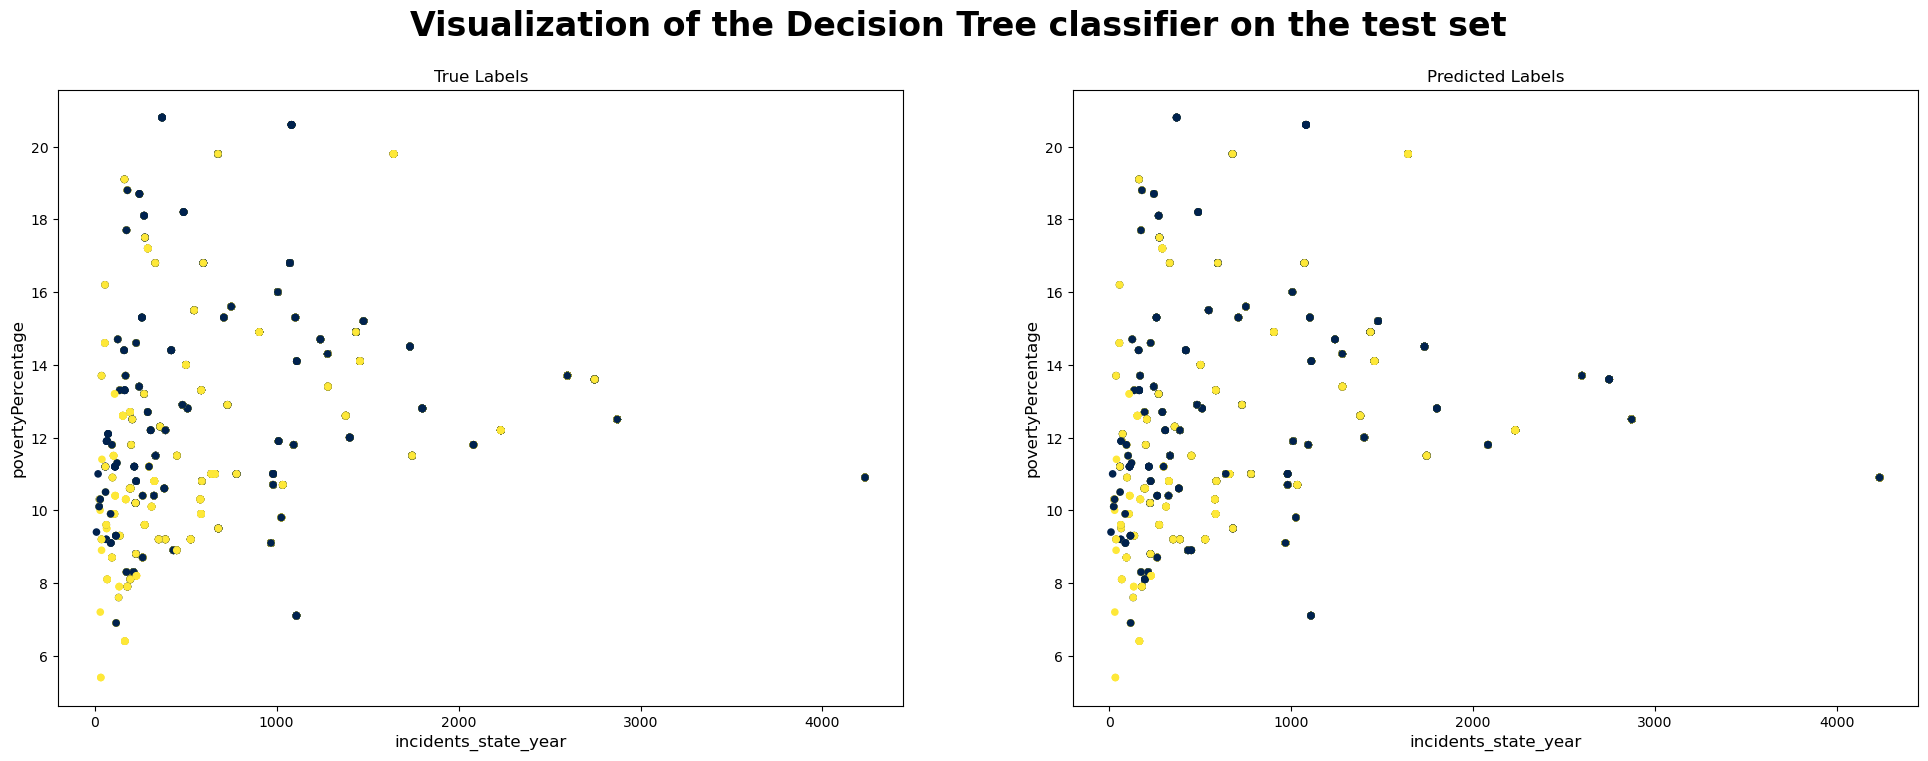

In [164]:
classification_visualizer(test_set, test_label, test_pred_dt, 'Decision Tree')

The accuracy of this model is optimal, also for the test set.The misclassified points are very few. This leads us to argue that the **Decision Tree is one of the best candidates to be the best model for our data**.

##### Confusion Matrix of the classifier

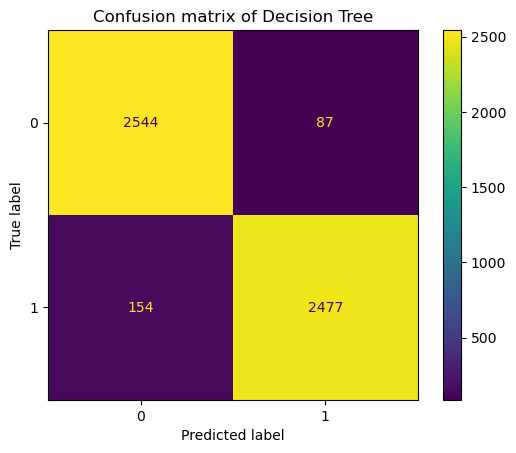

In [165]:
plot_c_matrix(test_set, test_label, test_pred_dt, dt, 'Decision Tree')

There are very few errors in class attribution for this model.

##### Visualization of the decision boundary of the classifier

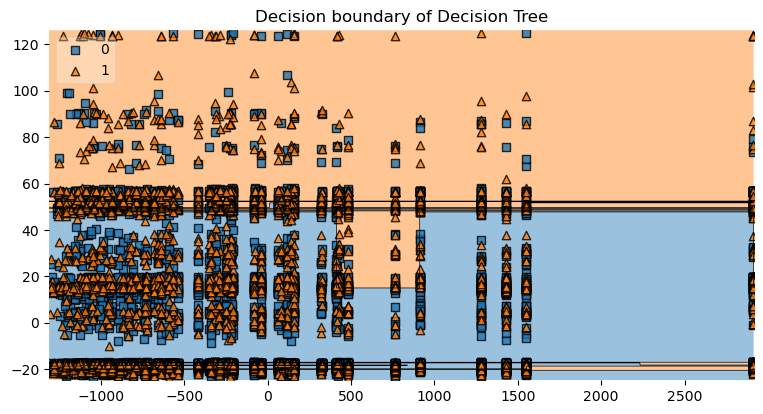

In [166]:
plot_decision_boundary(train_set, train_label, dt, 'Decision Tree')

The decision boundaries traced by this model for our data are geometric and so not-curvilinear: besides their shape, they seem to be quite precise and accurate.

# ------------------------------

### Classification with Ensemble Methods
This approach is really powerful because it is based on learning multiple classification models and returning as a result a combination of their different prediction (i.e. best trade-off). In this way this method ensure that no bias towards some class exists. The final combination of all the models, having each single one biased towards a specific class, results in an average of all these biases: therefore the final model is unbiased and reliable.

The fundamental property that must be guaranteed for this methods in order to have a good performance is that **models must be  independent**: this means that there is to be no relation between different classifiers.

#### Import libraries

In [167]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

An ensemble classifier constructs a set of base classifiers from the training data and performs classification by taking a vote on the predictions made by each base classifier. We consider 3 types of ensemble classifiers in the example below: **bagging, boosting, and random forest.**

#### Computing accuracy for three ensemble classifiers 

In the example below, we fit 500 base classifiers to our dataset using each ensemble method. The base classifier corresponds to a decision tree with maximum depth equals to 10.

In [168]:
numBaseClassifiers = 500
maxdepth = 10
trainAcc = []
testAcc = []

X_train = train_set.values
Y_train = train_label
X_test = test_set.values
Y_test = test_label

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

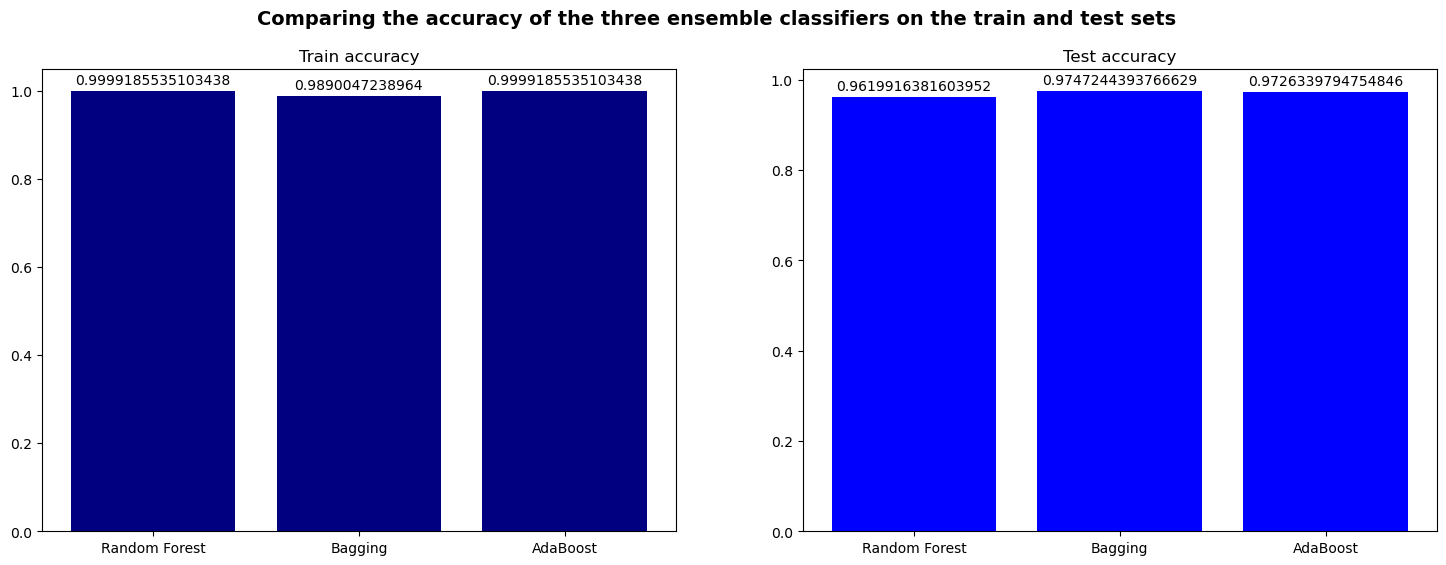

In [169]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

acc=[trainAcc, testAcc]
methods = ['Random Forest', 'Bagging', 'AdaBoost']
color = ['navy', 'blue', 'cyan']
title = ['Train accuracy', 'Test accuracy']
for i in range(2):
    autolabel(axs[i].bar([1.5,2.5,3.5], acc[i], color=color[i]), i)
    axs[i].set_xticks([1.5,2.5,3.5])
    axs[i].set_xticklabels(methods)
    axs[i].set_title(title[i])
    
plt.suptitle(('Comparing the accuracy of the three ensemble classifiers on the train and test sets'),
                 fontsize=14, fontweight='bold')
plt.show()

From the obtained results on the accuracy values we can see that all three models have good performance, both on training and on test data.

Now let's pick one to explore it deeply.


### Random Forest
Random Forest is a kind of Ensemble Method classifiers that works by manipulating input features.

This approach is based on Decision Tree classifiers: it basically consists in a forest of DTs, each one learned with a different subset of attributes. It combines the predictions made by multiple DTs and outputs the class that is the **mode** of the class's output by individual trees.

In this project we use the [Scikit Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the *max_samples* parameter if *bootstrap* is True, otherwise the whole dataset is used to build each tree.

#### Guarantee a good performance
In case the number of attributes is too low, the different DTs in the forest may not be independento from each other: in fact, correlation between models depends on the number of sttributes that populates each tree.
This can be a problem for the resulting performance of algorithm based on ensemble method, like random forest itself. 

So if the model is learning too few features, the resulting performance of the classifier may not be good.

For this reason the *max_features* parameter is used to control this functioning and ensure a satisfying performance of the model. 



#### Grid search
To find the best set of parameters (because it strongly depends on data).

In [170]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": [None, "sqrt", "log2"] + list(range(1, len(train_set.iloc[0]) + 1)),
              "min_samples_split": randint(10, 51),
              "min_samples_leaf": randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', 'balanced_subsample', None]}
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=30)
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': [None, 'sqrt', 'log2',
                                                         1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbdd458e290>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbdd458e4d0>},
                   scoring=make_scorer(accuracy_score))

Print the best set of hyperparameters for this dataset.

In [171]:
print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 27, 'min_samples_split': 35}

Mean of this setting
 0.9543086966040188 

Standard Deviation (std) of this setting
 0.0029387565990381397


#### Run the model: without class weights

In [172]:
rf = RandomForestClassifier(n_estimators=30,
                             criterion='gini',
                             max_features='log2', 
                             min_samples_split=42,
                             min_samples_leaf=12,
                             max_depth = None,
                             bootstrap=True)
rf = rf.fit(train_set, train_label)
train_pred_rf = rf.predict(train_set)

test_pred_rf = rf.predict(test_set)

#### Probabilities

In [173]:
test_pred_proba_rf = rf.predict_proba(test_set)

In [174]:
test_pred_proba_rf

array([[0.60328912, 0.39671088],
       [0.98685154, 0.01314846],
       [0.98794102, 0.01205898],
       ...,
       [0.09177223, 0.90822777],
       [0.99795523, 0.00204477],
       [0.66118882, 0.33881118]])

#### Evaluation

##### Model performance on the training set

In [175]:
report_scores(train_label, train_pred_rf)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6139
           1       0.95      0.97      0.96      6139

    accuracy                           0.96     12278
   macro avg       0.96      0.96      0.96     12278
weighted avg       0.96      0.96      0.96     12278



##### Model performance on the test set

In [176]:
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2631
           1       0.93      0.95      0.94      2631

    accuracy                           0.94      5262
   macro avg       0.94      0.94      0.94      5262
weighted avg       0.94      0.94      0.94      5262



The values obtained for precision and recall on all three classes are really good. Also the accuracy has a really good result.

This is probably another model to be candidate as the one of the best for our data.

##### Visualization of the classifier results via scatterplots

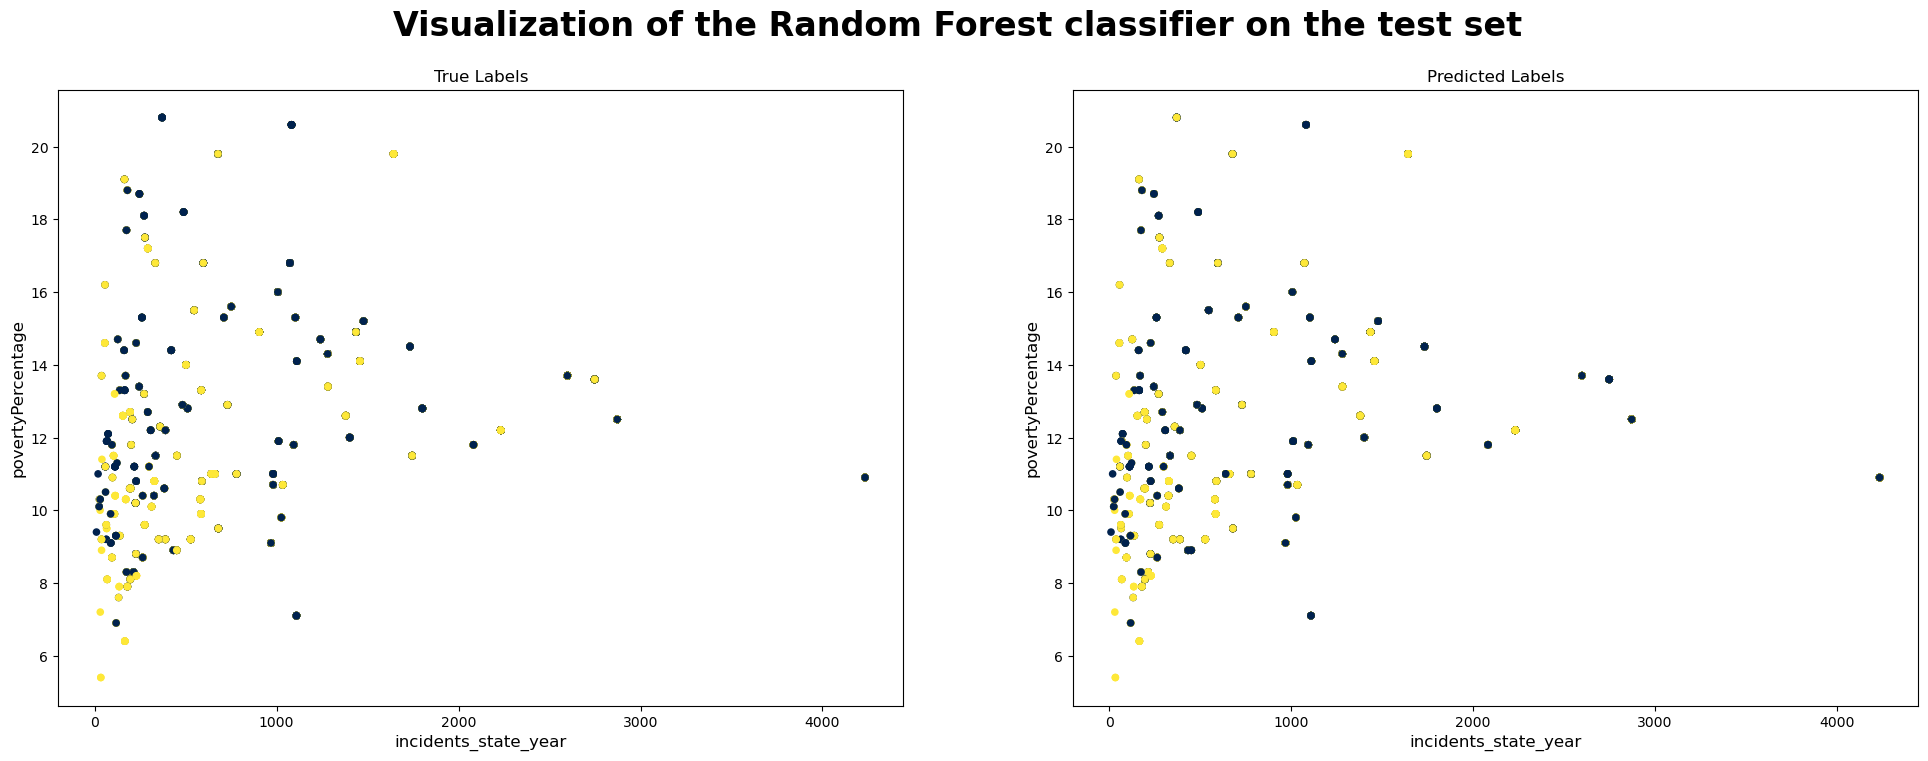

In [177]:
classification_visualizer(test_set, test_label, test_pred_rf, 'Random Forest')

Misclassified points are really few and the prediction on test labels is quite accurate.

##### Confusion Matrix of the classifier

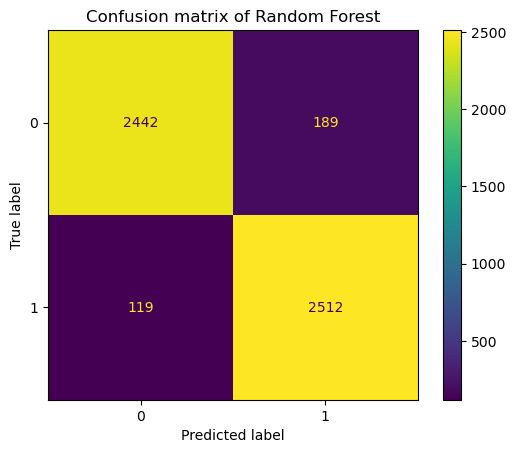

In [178]:
plot_c_matrix(test_set, test_label, test_pred_rf, rf, 'Random Forest')

In this case, the class that reports more errors is that of medium spending, erroneously classified as high spending.

##### Visualization of the decision boundary of the classifier

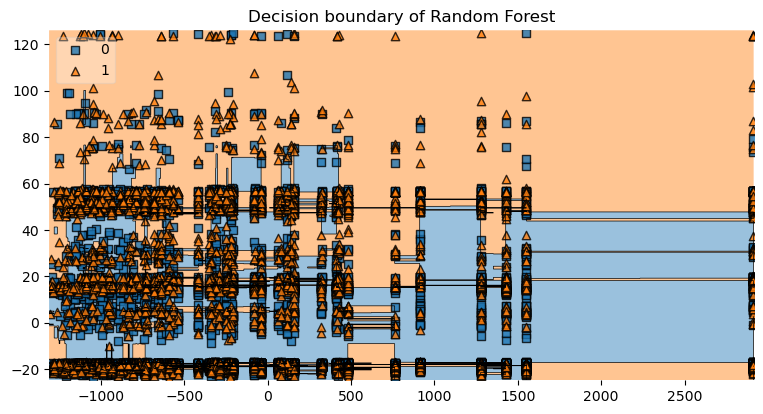

In [179]:
plot_decision_boundary(train_set, train_label, rf, 'Random Forest')

As the Decision Tree, also the Random Forest classifier has geometric boundaries. They also seem to be quite accurate in the space division.

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

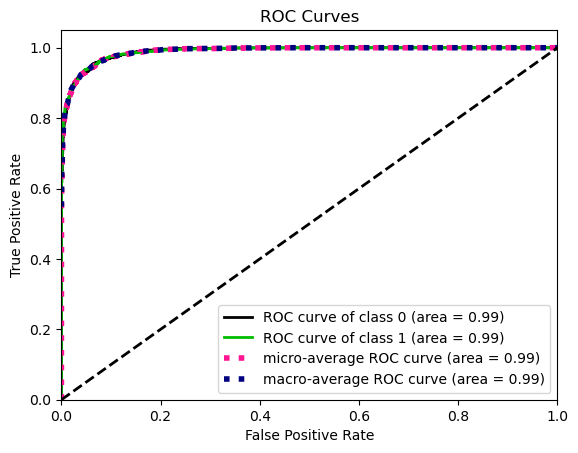

In [180]:
skplt.metrics.plot_roc(test_label, test_pred_proba_rf)

The slightly lower performances shown by the graph in relation to the classification of medium-spending customers follow what has already been said about the frequent confusion of the latter with high-sending customers.

#### Random Forest final considerations 

We have seen that the Random Forest is a very powerful model: in general, we know from the literature that classifiers based on ensemble method often guarantee great performances.

##### Advantages
- It is one of the most accurate learning algorithms available. For many data sets, it produces a high accurate classifier.
- It runs efficiently on large databases: since running DTs is fast, this approach is convenient. Learning is not too costly.
- It can handle thousands of input variables without variable deletion.
- It gives estimates of what variables are important in the classification.
- It generates an internal unbiased estimate of the generalization error as the forest building progresses.

### Voting classifier

The idea behind the [Scikit VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

For this reason we considered this algorithm very interesting in the context of ensemble methods and also *new* (compared to the algorithms we have seen in class), and so we decided to include it in our analysis.

#### Run the model

In [181]:
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
                        ('SVM', svm), 
                        ('Decision Tree', dt), 
                        ('GaussianNB', gnb),  
                        ('RandomForest', rf),
                        ('MLP', mlp)
                        ], voting='soft')

vc.fit(train_set.values, train_label)

VotingClassifier(estimators=[('SVM',
                              SVC(C=0.5, decision_function_shape='ovo',
                                  probability=True)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=7,
                                                     min_samples_leaf=3,
                                                     min_samples_split=28)),
                             ('GaussianNB', GaussianNB()),
                             ('RandomForest',
                              RandomForestClassifier(max_features='log2',
                                                     min_samples_leaf=12,
                                                     min_samples_split=42,
                                                     n_estimators=30)),
                             ('MLP',
                              MLPClassifier(activation='tanh', max_iter=300,
                                            random_state=1))],
                 voting='soft')

In [182]:
train_pred_vc = vc.predict(train_set)
train_pred_vc

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 1, 1, 0])

In [183]:
test_pred_vc = vc.predict(test_set)
test_pred_vc

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 1, 0, 0])

In contrast to majority voting (hard voting), soft voting returns the class label as argmax of the sum of predicted probabilities.

Specific weights can be assigned to each classifier via the weights parameter. When weights are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability.

##### Probabilities

In [184]:
test_pred_proba_vc = vc.predict_proba(test_set)
test_pred_proba_vc

/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/lospiri/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([[0.65022818, 0.34977182],
       [0.88375628, 0.11624372],
       [0.85831439, 0.14168561],
       ...,
       [0.26554701, 0.73445299],
       [0.85880157, 0.14119843],
       [0.5302031 , 0.4697969 ]])

#### Evaluation

##### Model performance on the training set

In [185]:
report_scores(train_label,train_pred_vc)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6139
           1       0.97      0.97      0.97      6139

    accuracy                           0.97     12278
   macro avg       0.97      0.97      0.97     12278
weighted avg       0.97      0.97      0.97     12278



##### Model performance on the test set

In [186]:
report_scores(test_label,test_pred_vc)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2631
           1       0.96      0.97      0.97      2631

    accuracy                           0.97      5262
   macro avg       0.97      0.97      0.97      5262
weighted avg       0.97      0.97      0.97      5262



Also this model results to have good values on prediction performances, both on train and on tests set.

We confirm what was said above about the good effectiveness of ensemble classifiers.

##### Visualization of the classifier results via scatterplots

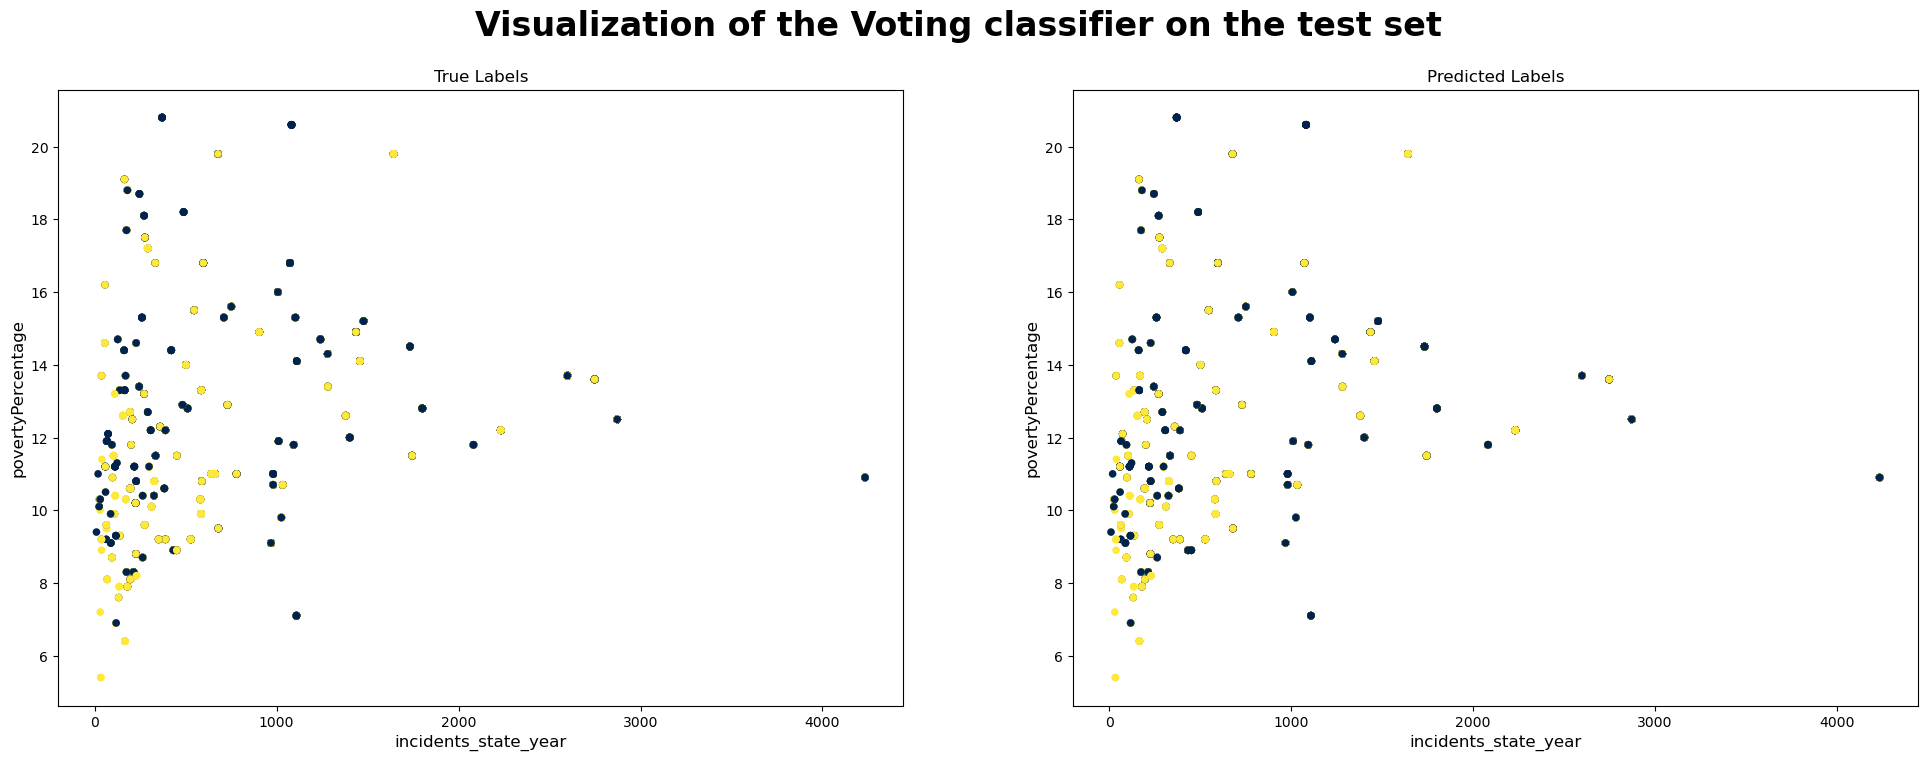

In [187]:
classification_visualizer(test_set, test_label, test_pred_vc, 'Voting')

##### Confusion Matrix of the classifier

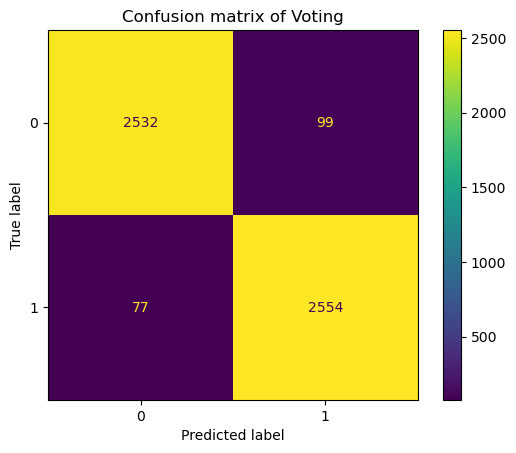

In [188]:
plot_c_matrix(test_set, test_label, test_pred_vc, vc, 'Voting')

Misclassified points as well as errors in the arribution of the class are very few.

##### Visualization of the decision boundary of the classifier

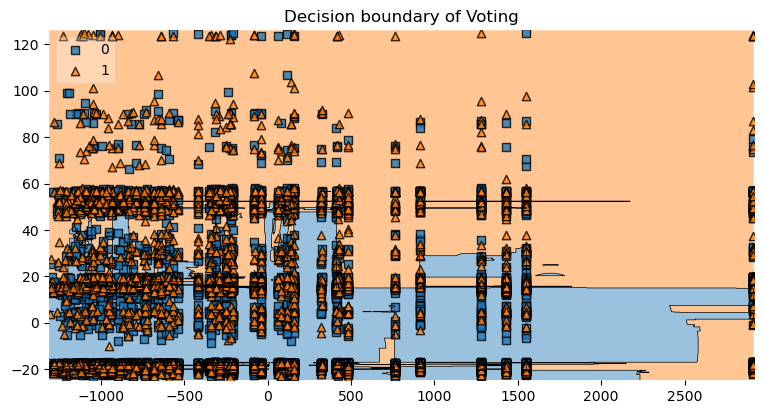

In [189]:
plot_decision_boundary(train_set, train_label, vc, 'Voting')

The fact that the decision boundaries for this model have both straight and curvilinear lines could result from the fact that it is a combination of other models. However, the hyperplanes seem to accurately divide the data into the three classes.

##### ROC curve of the classifier

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

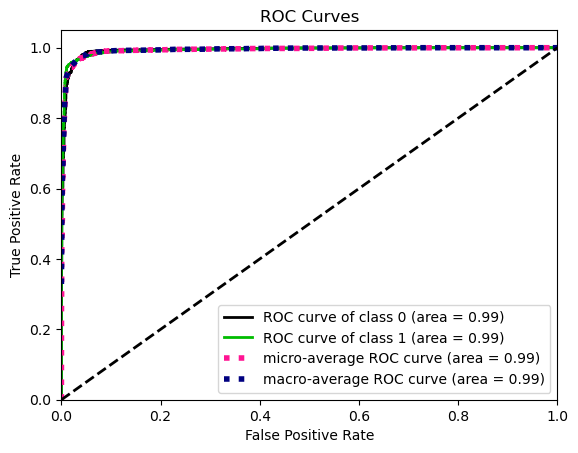

In [190]:
skplt.metrics.plot_roc(test_label, test_pred_proba_vc)